# Import libraries

In [ ]:
from collections import Counter
import warnings

import pandas as pd
import numpy as np
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler, FunctionTransformer, RobustScaler
from sklearn.feature_selection import (
    f_classif,
    mutual_info_classif
)
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest, RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from matplotlib import pyplot as plt
from pickle import dump, load


%matplotlib inline
warnings.filterwarnings("once")

In [2]:
class MySMOTENC():
    
    def __init__(
            self, categorical_features, k_neighbors=5, random_state=None
    ):
        self.categorical_features = categorical_features
        self.k_neighbors = k_neighbors
        self.random_state = random_state

    def fit_resample(self, X: pd.DataFrame, y: pd.Series | pd.DataFrame):
        ## save current seed to rollback it after change
        ## by self.random_state
        prev_random_seed = np.random.get_state()
        np.random.seed(self.random_state)
        cnt_classes = Counter(y)
        data = X.copy(deep=True)
        data.reset_index(drop=True, inplace=True)
        numeric_columns = data.drop(columns=self.categorical_features).columns.to_list()
        if isinstance(y, pd.DataFrame):
            target = y.iloc[:, 0].copy().reset_index(drop=True)
        else:
            target = y.copy().reset_index(drop=True)
        ## most_common return list of tuples [(key, val), ...]
        majority_class, majority_size = cnt_classes.most_common(1)[0]
        cnt_classes.pop(majority_class)
        ## + 1 to find neighbors exclude sample itself
        nbrs = NearestNeighbors(n_neighbors=self.k_neighbors + 1, algorithm="kd_tree")
        synt_list = [data]
        synt_target_list = [target]
        for cl, cl_size in cnt_classes.items():
            generate_size = majority_size // 2 - cl_size
            if generate_size < 1:
                continue
            cl_data = data.loc[target == cl]
            nbrs.fit(cl_data)
            nbrs_list = nbrs.kneighbors(return_distance=False)
            sample_inds = np.random.randint(0, cl_data.shape[0], generate_size)
            neigh_inds = np.array([
                np.random.choice(nbrs_list[id])
                for id in sample_inds
            ])
            lambdas = np.random.uniform(0.2, 0.8, generate_size).reshape((-1, 1))
            ## is simplest interpolation (1 - lambda) * P1 + lambda * P2
            synt_numeric = (1 - lambdas) * cl_data.loc[
                cl_data.index[sample_inds], numeric_columns
            ].to_numpy() + lambdas * cl_data.loc[
                cl_data.index[neigh_inds], numeric_columns
            ].to_numpy()
            ## for each categ col select majoritary label from neighbors
            synt_categ = np.vstack([
                [
                    Counter(cl_data.loc[cl_data.index[sampled_rows], col]).most_common(1)[0][0]
                    for col in self.categorical_features
                ]
                for sampled_rows in nbrs_list[sample_inds]
            ])
            synt_list.append(pd.DataFrame(
                np.hstack([synt_numeric, synt_categ]),
                columns=numeric_columns + self.categorical_features))
            synt_target_list.append(pd.Series([cl] * generate_size, name=target.name))

        data = pd.concat(synt_list, axis=0)
        target = pd.concat(synt_target_list, axis=0)
        np.random.set_state(prev_random_seed)
        return data, target


class BaseClassifier(ClassifierMixin, BaseEstimator):

    def __init__(
            self, estimator, num_cols, cat_cols,
            need_impute=True, need_balance=True, need_scale=True,
            feature_selection: str | None=None
        ):
        self.estimator = estimator
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.need_impute = need_impute
        self.need_balance = need_balance
        self.need_scale = need_scale
        self.feature_selection = feature_selection
        self._selector = None
        self._num_robust_scaler = ColumnTransformer(
            [("scaler", RobustScaler(), self.num_cols)],
            remainder="passthrough"
        )
        self._num_imputer = IterativeImputer(
            estimator=RandomForestRegressor(
                n_estimators=30, max_depth=3,
                max_features=0.3, random_state=17
            ), max_iter=2,
            random_state=17, missing_values=np.nan
        )
        self._cat_predictors = {}
        self._scaler = ColumnTransformer(
            [
                ("std_scaler", StandardScaler(), [
                    col for col in self.num_cols if col in {
                        "popularity", "danceability", "energy", "loudness",
                        "valence", "tempo", "vowels_ratio", "consonants_ratio"
                    }
                ]),
                ("log_scaler", FunctionTransformer(
                    lambda x: np.log10(x + 1e-14), lambda x: np.power(10, x)
                    ), [
                    col for col in self.num_cols if col in {
                        "speechiness", "acousticness", "instrumentalness",
                        "liveness", "duration_ms", "name_len"
                    }
                ])
            ],
            remainder="passthrough"
        )
    
    def _fill_cat_missing(self, X: pd.DataFrame):
        ## fill na in cat features by random forest
        na_cat_feat = np.array(self.cat_cols)[X.loc[:, self.cat_cols].isna().any(axis=0)]
        for cat in na_cat_feat:
            missing = X.loc[:, cat].isna()
            X_train = X.loc[~missing].drop(cat, axis=1)
            X_test = X.loc[missing].drop(cat, axis=1)
            y_train = X.loc[~missing, cat]
            if str(cat) not in self._cat_predictors:
                self._cat_predictors[str(cat)] = RandomForestClassifier(
                    n_estimators=50, random_state=17,
                    max_features="sqrt", max_depth=15
                )
                self._cat_predictors[str(cat)].fit(X_train, y_train)
            X.loc[missing, cat] = self._cat_predictors[str(cat)].predict(X_test).ravel()
        return X

    def _imputing(self, X: pd.DataFrame, col_names: list[str], fit_stage: bool):
        ## fill na in cat features by random forest
        if self.cat_cols != []:
            X = self._fill_cat_missing(X)
        if fit_stage:
            ## impute continuous features
            imputed = self._num_imputer.fit_transform(
                self._num_robust_scaler.fit_transform(X)
            )
        else:
            ## impute continuous features by predefined imputer
            imputed = self._num_imputer.transform(
                self._num_robust_scaler.transform(X)
            )
        ## transformers_ is list like [(name, fitted_transformer, column), ...]
        ## inverse transform of numeric features
        imputed[:, :len(self.num_cols)] = self._num_robust_scaler.transformers_[0][1]\
                .inverse_transform(imputed[:, :len(self.num_cols)])
        imputed = pd.DataFrame(
            imputed,
            columns=list(self.num_cols) + list(self.cat_cols)
        )
        return imputed.loc[:, col_names]
    
    def _balancing(self, X: pd.DataFrame, y: pd.DataFrame | pd.Series) -> tuple:
        return MySMOTENC(self.cat_cols, 15, 17).fit_resample(X, y)
    
    def _scaling(self, X: pd.DataFrame, col_names: list[str], fit_stage: bool):
        if fit_stage:
            scaled = pd.DataFrame(
                self._scaler.fit_transform(X),
                columns=[
                        col for col in self.num_cols if col in {
                            "popularity", "danceability", "energy", "loudness",
                            "valence", "tempo", "vowels_ratio", "consonants_ratio"
                        }
                ] + [
                        col for col in self.num_cols if col in {
                            "speechiness", "acousticness", "instrumentalness",
                            "liveness", "duration_ms", "name_len"
                        }
                ] +  list(self.cat_cols)
            )
            return scaled.loc[:, col_names]
        scaled = pd.DataFrame(
            self._scaler.transform(X),
            columns=[
                    col for col in self.num_cols if col in {
                        "popularity", "danceability", "energy", "loudness",
                        "valence", "tempo", "vowels_ratio", "consonants_ratio"
                    }
            ] + [
                    col for col in self.num_cols if col in {
                        "speechiness", "acousticness", "instrumentalness",
                        "liveness", "duration_ms", "name_len"
                    }
            ] +  list(self.cat_cols)
        )
        return scaled.loc[:, col_names]
    
    def fit(self, X: pd.DataFrame, y: pd.Series | pd.DataFrame | None=None):
        if self.cat_cols is None:
            self.cat_cols = []
        else:
            self.cat_cols = [str(col) for col in self.cat_cols]
        if y is None and self.need_balance:
            raise ValueError("to balance data is necessary to provide `y`")
        self.num_cols = [str(col) for col in self.num_cols]
        col_names = X.columns.to_list()
        X_copy = X.copy(deep=True)
        if self.need_impute:
            X_copy = self._imputing(X_copy, col_names, True)
        
        if self.need_balance:
            X_copy, y = self._balancing(X_copy, y)
        
        if self.need_scale:
            X_copy = self._scaling(X_copy, col_names, True)

        self.estimator.fit(X_copy, y)
        self.classes_ = self.estimator.classes_
        self._is_fitted = True
        return self
    
    def _predict(self, X: pd.DataFrame, proba: bool):
        if not hasattr(self, "_is_fitted") or not self._is_fitted:
            raise NotFittedError("BaseClassifier is not fitted yet")
        col_names = X.columns.to_list()
        if self.need_impute:
            X = self._imputing(X,  col_names=col_names, fit_stage=False)
        if self.need_scale:
            X = self._scaling(X, col_names, False)
        if proba:
            return self.estimator.predict_proba(X)
        return self.estimator.predict(X)
    
    def predict(self, X):
        return self._predict(X, False)
    
    def predict_proba(self, X):
        return self._predict(X, True)
    
    def set_params(self, **kwargs):
        self._is_fitted = False
        self.estimator.set_params(**kwargs)
        return self
    
    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted


# Exploration analysis

In [225]:
df = pd.read_csv("data_files/train.csv")
df.rename(columns={
    "Artist Name": "artist", "Track Name": "track",
    "Popularity": "popularity", "duration_in min/ms": "duration_ms",
    "Class": "class"
}, inplace=True)

In [236]:
# get categorical columns
categ_col = [col for col in df.columns if df.loc[:, col].nunique() < 50]
print("categorical columns", categ_col)
for col in categ_col:
    df[col] = pd.Categorical(df.loc[:, col])

categorical columns ['key', 'mode', 'time_signature', 'class']


In [6]:
# each column has appropriate dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   artist            17996 non-null  object  
 1   track             17996 non-null  object  
 2   popularity        17568 non-null  float64 
 3   danceability      17996 non-null  float64 
 4   energy            17996 non-null  float64 
 5   key               15982 non-null  category
 6   loudness          17996 non-null  float64 
 7   mode              17996 non-null  category
 8   speechiness       17996 non-null  float64 
 9   acousticness      17996 non-null  float64 
 10  instrumentalness  13619 non-null  float64 
 11  liveness          17996 non-null  float64 
 12  valence           17996 non-null  float64 
 13  tempo             17996 non-null  float64 
 14  duration_ms       17996 non-null  float64 
 15  time_signature    17996 non-null  category
 16  class             1799

In [61]:
# min duration_ms is too small, lower than 0
df.drop("class", axis=1).iloc[:, :10].describe()

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness
count,15856.000000,16253.000000,16253.000000,16253.000000,16253.000000,16253.000000,12178.000000
mean,43.995396,0.545409,0.652586,-8.047563,0.080745,0.262312,0.180248
std,17.461785,0.167321,0.239215,4.149642,0.085568,0.317336,0.307258
min,1.000000,0.059600,0.000020,-39.952000,0.022500,0.000000,0.000001
25%,32.000000,0.433000,0.492000,-9.743000,0.034800,0.005600,0.000084
50%,43.000000,0.547000,0.690000,-7.115000,0.047200,0.096700,0.003920
75%,56.000000,0.663000,0.853000,-5.233000,0.083800,0.471000,0.205000
max,100.000000,0.989000,1.000000,1.355000,0.955000,0.996000,0.996000


In [63]:
df.drop("class", axis=1).iloc[:, 10:].describe()

,liveness,valence,tempo,duration_ms
count,16253.000000,16253.000000,16253.000000,1.625300e+04
mean,0.195966,0.482143,122.179808,2.368201e+05
std,0.160355,0.241176,29.674497,8.677515e+04
min,0.011900,0.018300,30.557000,2.332000e+04
25%,0.097700,0.291000,98.922000,1.879200e+05
50%,0.128000,0.475000,120.004000,2.206190e+05
75%,0.255000,0.669000,141.393000,2.645330e+05
max,1.000000,0.986000,217.416000,1.793160e+06


In [226]:
# convert duration in minutes to duration in ms
df.loc[df.loc[:, "duration_ms"] < 1e2, "duration_ms"] *= 6e4
df.loc[:, ["duration_ms"]].describe()

,duration_ms
count,1.799600e+04
mean,2.358233e+05
std,8.567503e+04
min,2.332000e+04
25%,1.876497e+05
50%,2.200000e+05
75%,2.630822e+05
max,1.793160e+06


In [10]:
# track may contains non latin letters
df.sample(5)

,artist,track,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,class
11206,Roy Hall,Three Alley Cats,7.0,0.651,0.676,5.0,-4.224,0,0.0522,0.7850,NaN,0.1480,0.779,175.366,148640.0,4,10
15522,Arik Einstein,◊í◊ô◊ò◊®◊î ◊ï◊õ◊ô◊†◊ï◊®,46.0,0.537,0.391,4.0,-10.797,1,0.0264,0.8420,0.030200,0.1190,0.379,73.008,216467.0,4,10
6524,Noah Cunane,BOY WITH A BROKEN HEART,49.0,0.616,0.753,7.0,-5.912,1,0.0485,0.1060,NaN,0.2670,0.553,85.002,178932.0,4,5
12505,Friday Pilots Club,I Don't Care,40.0,0.583,0.573,8.0,-5.420,1,0.0811,0.2080,NaN,0.2850,0.783,184.062,233630.0,4,1
8965,K. S. Harisankar,Mukthi,23.0,0.507,0.750,NaN,-8.351,0,0.0446,0.0866,0.000009,0.0943,0.487,127.939,196875.0,4,0


## Remove uninformative column

In [11]:
# track should be deleted because it has too many unique values
df.loc[:, ["artist", "track"]].nunique()

artist     9149
track     15129
dtype: int64

In [227]:
df = df.drop("track", axis=1)

## Check duplicated records

In [14]:
# there are duplicated records
# interestingly that duplicated records have differente target value
df.loc[df.drop(columns="class", axis=1).duplicated(keep=False)]\
    .sort_values(["artist", "popularity"])\
        .loc[:, ["artist", "popularity", "time_signature", "class"]]

,artist,popularity,time_signature,class
1541,'68,36.0,4,1
9110,'68,36.0,4,6
14069,'68,36.0,4,10
6209,*repeat repeat,23.0,4,10
10838,*repeat repeat,23.0,4,1
...,...,...,...,...
16390,young friend,58.0,4,6
6535,◊©◊ù ◊ò◊ï◊ë ◊î◊ê◊ë◊ô,46.0,4,9
7415,◊©◊ù ◊ò◊ï◊ë ◊î◊ê◊ë◊ô,46.0,4,5
1543,◊ê◊ë◊ô◊ë ◊û◊ê◊®◊ß,4.0,4,6


In [15]:
# 1743 duplicated records
sum(df.drop("class", axis=1).duplicated(keep="first"))

1743

In [228]:
df = df.loc[~df.drop("class", axis=1).duplicated(keep="first")]

## Check missing values

In [17]:
# deletion of 25% rows is impracticable
df.isna().sum() / df.shape[0] * 100 // 1

artist               0.0
popularity           2.0
danceability         0.0
energy               0.0
key                 11.0
loudness             0.0
mode                 0.0
speechiness          0.0
acousticness         0.0
instrumentalness    25.0
liveness             0.0
valence              0.0
tempo                0.0
duration_ms          0.0
time_signature       0.0
class                0.0
dtype: float64

In [18]:
df.loc[df.loc[:, "popularity"].isna(), "class"].value_counts() /\
    df.loc[:, "class"].value_counts() * 100

class
0     11.840000
1      2.330508
2      1.233553
3      3.482587
4      5.167959
5      1.566952
6      1.630941
7      5.034722
8      1.617562
9      2.596315
10     1.714028
Name: count, dtype: float64

In [19]:
# for some classes instrumentalness has over a half of missing values
df.loc[df.loc[:, "instrumentalness"].isna(), "class"].value_counts() /\
    df.loc[:, "class"].value_counts() * 100

class
0     22.080000
1     11.652542
2     11.101974
3     24.129353
4     53.488372
5     59.971510
6      9.645853
7      0.173611
8      8.030040
9     50.795645
10    22.237258
Name: count, dtype: float64

In [20]:
df.loc[df.loc[:, "key"].isna(), "class"].value_counts() /\
    df.loc[:, "class"].value_counts() * 100

class
0     11.040000
1     11.122881
2     14.638158
3      7.711443
4     10.852713
5      8.190883
6     10.857409
7     15.104167
8      8.954362
9     12.102178
10    11.727560
Name: count, dtype: float64

## Feature extraction

In [229]:
# since artist has string type and particular name
# is not valuable, so it's necessary to map artist name
# to numeric features
df.loc[:, "name_len"] = df.loc[:, "artist"].apply(lambda x: len(x))
df.loc[:, "vowels_ratio"] = df.loc[:, "artist"].apply(
    lambda x: sum(map(x.lower().count, "aeuio")) / len(x)
)
df.loc[:, "consonants_ratio"] = df.loc[:, "artist"].apply(
    lambda x: sum(map(x.lower().count, "qwrtpsdfgjklmnzxcvbny")) / len(x)
)

## Visualization

In [237]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop("class", axis=1), df.loc[:, "class"], test_size=0.2,
    random_state=17, shuffle=True, stratify=df.loc[:, "class"]
)
numeric_cols = x_train.select_dtypes(exclude=["category", "object"]).columns.to_list()
categ_cols = x_train.select_dtypes(include=["category", "object"]).columns.to_list()

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


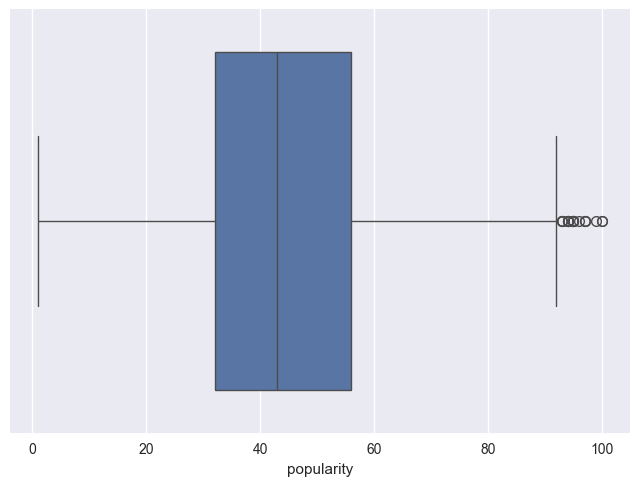

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


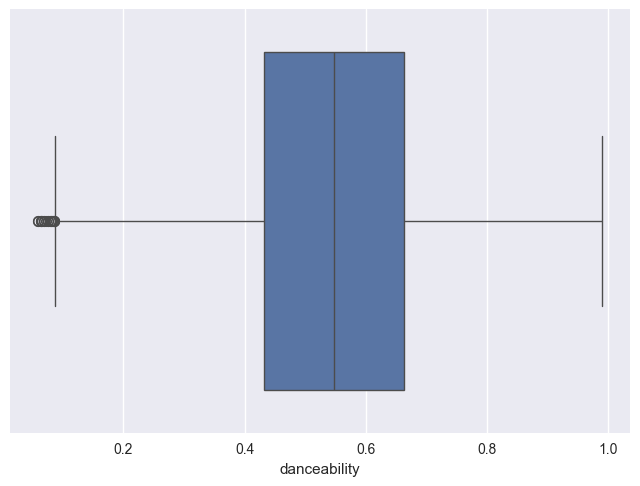

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


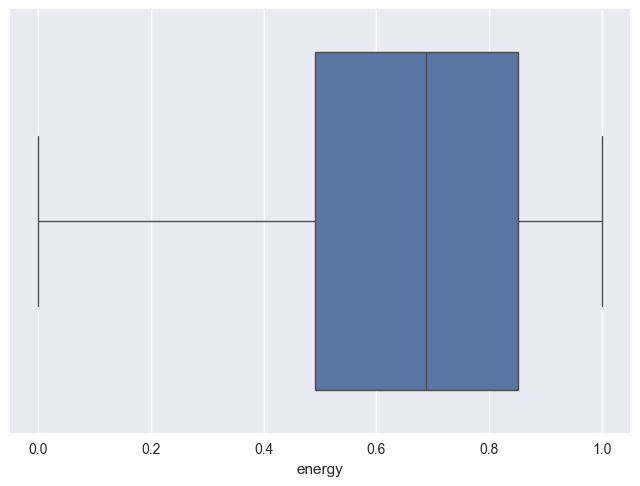

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


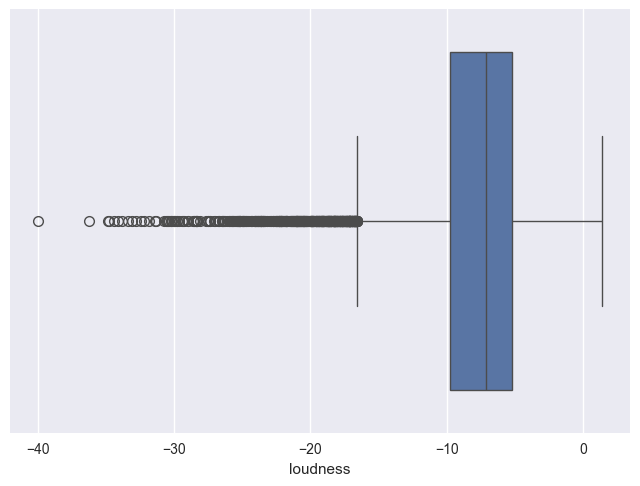

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


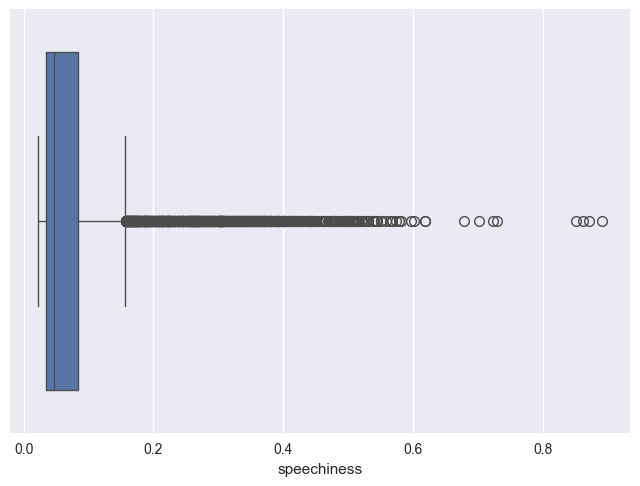

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


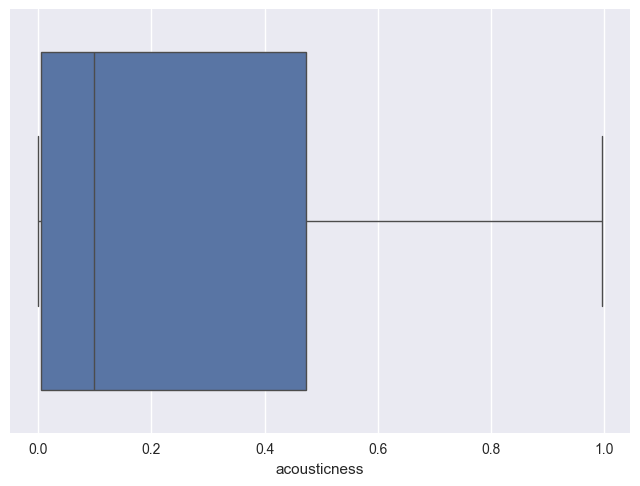

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


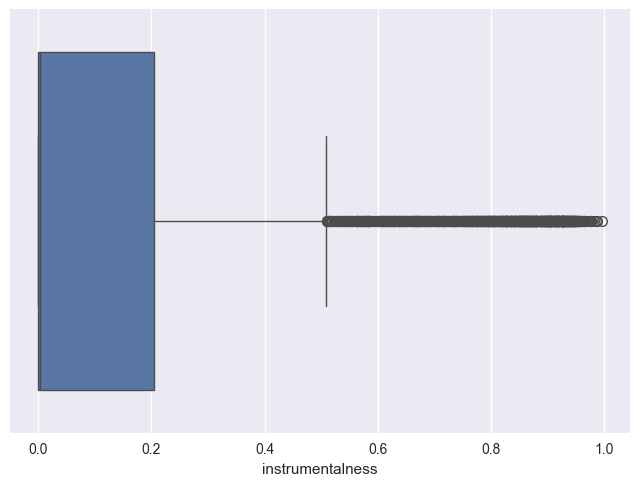

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


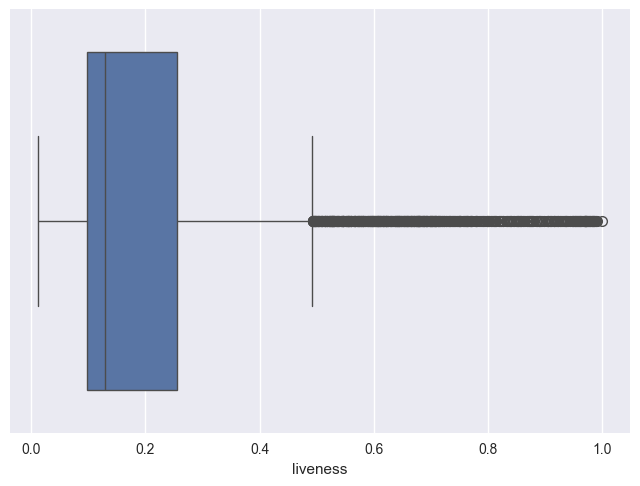

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


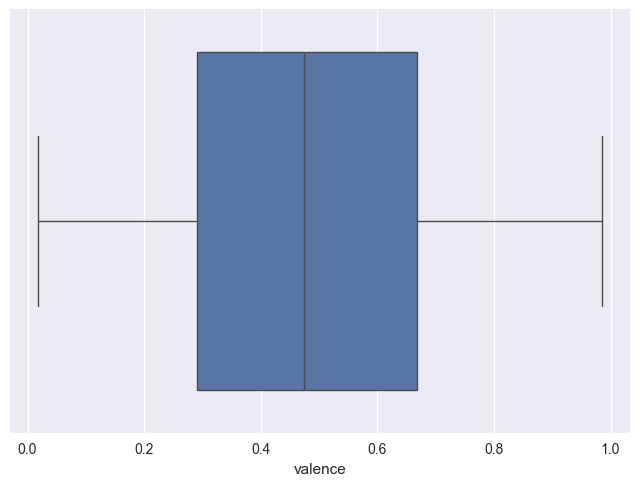

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


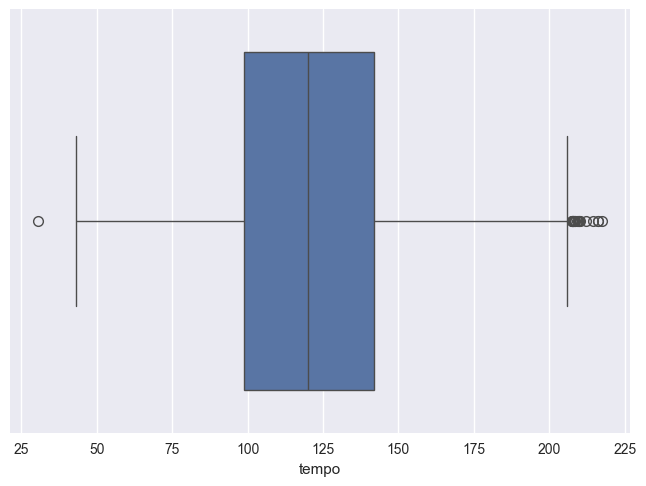

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


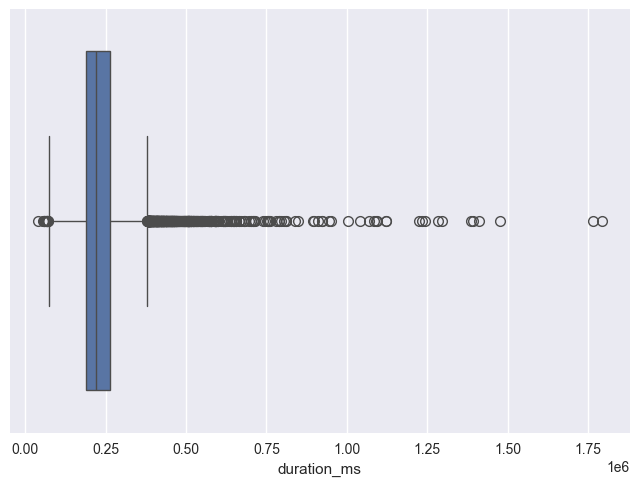

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


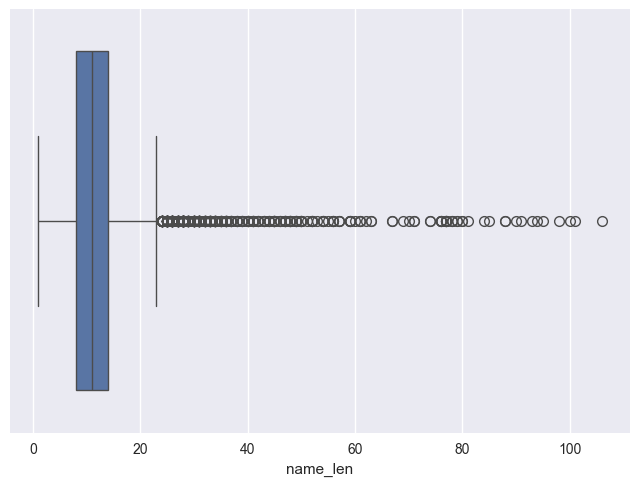

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


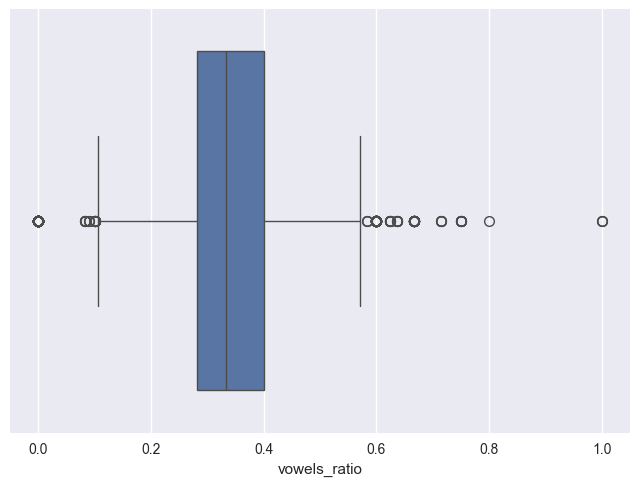

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


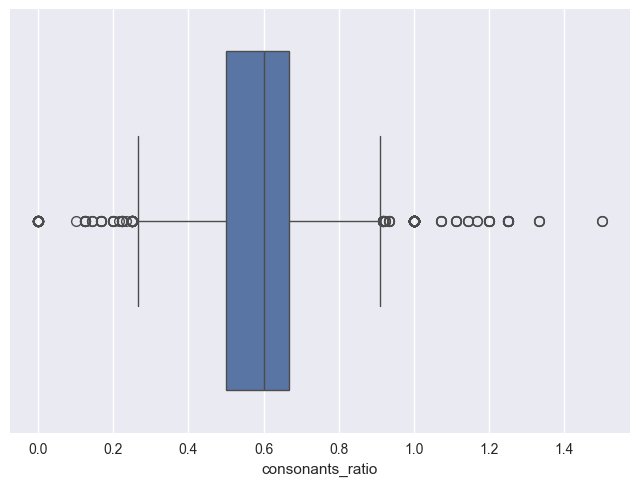

In [38]:
# there is features with skewness,
# it's probably worth to remove anomalies
with plt.style.context("seaborn-v0_8"):
    for col in x_train.select_dtypes(np.number).columns:
        sns.boxplot(x=x_train.loc[:, col])
        plt.show();

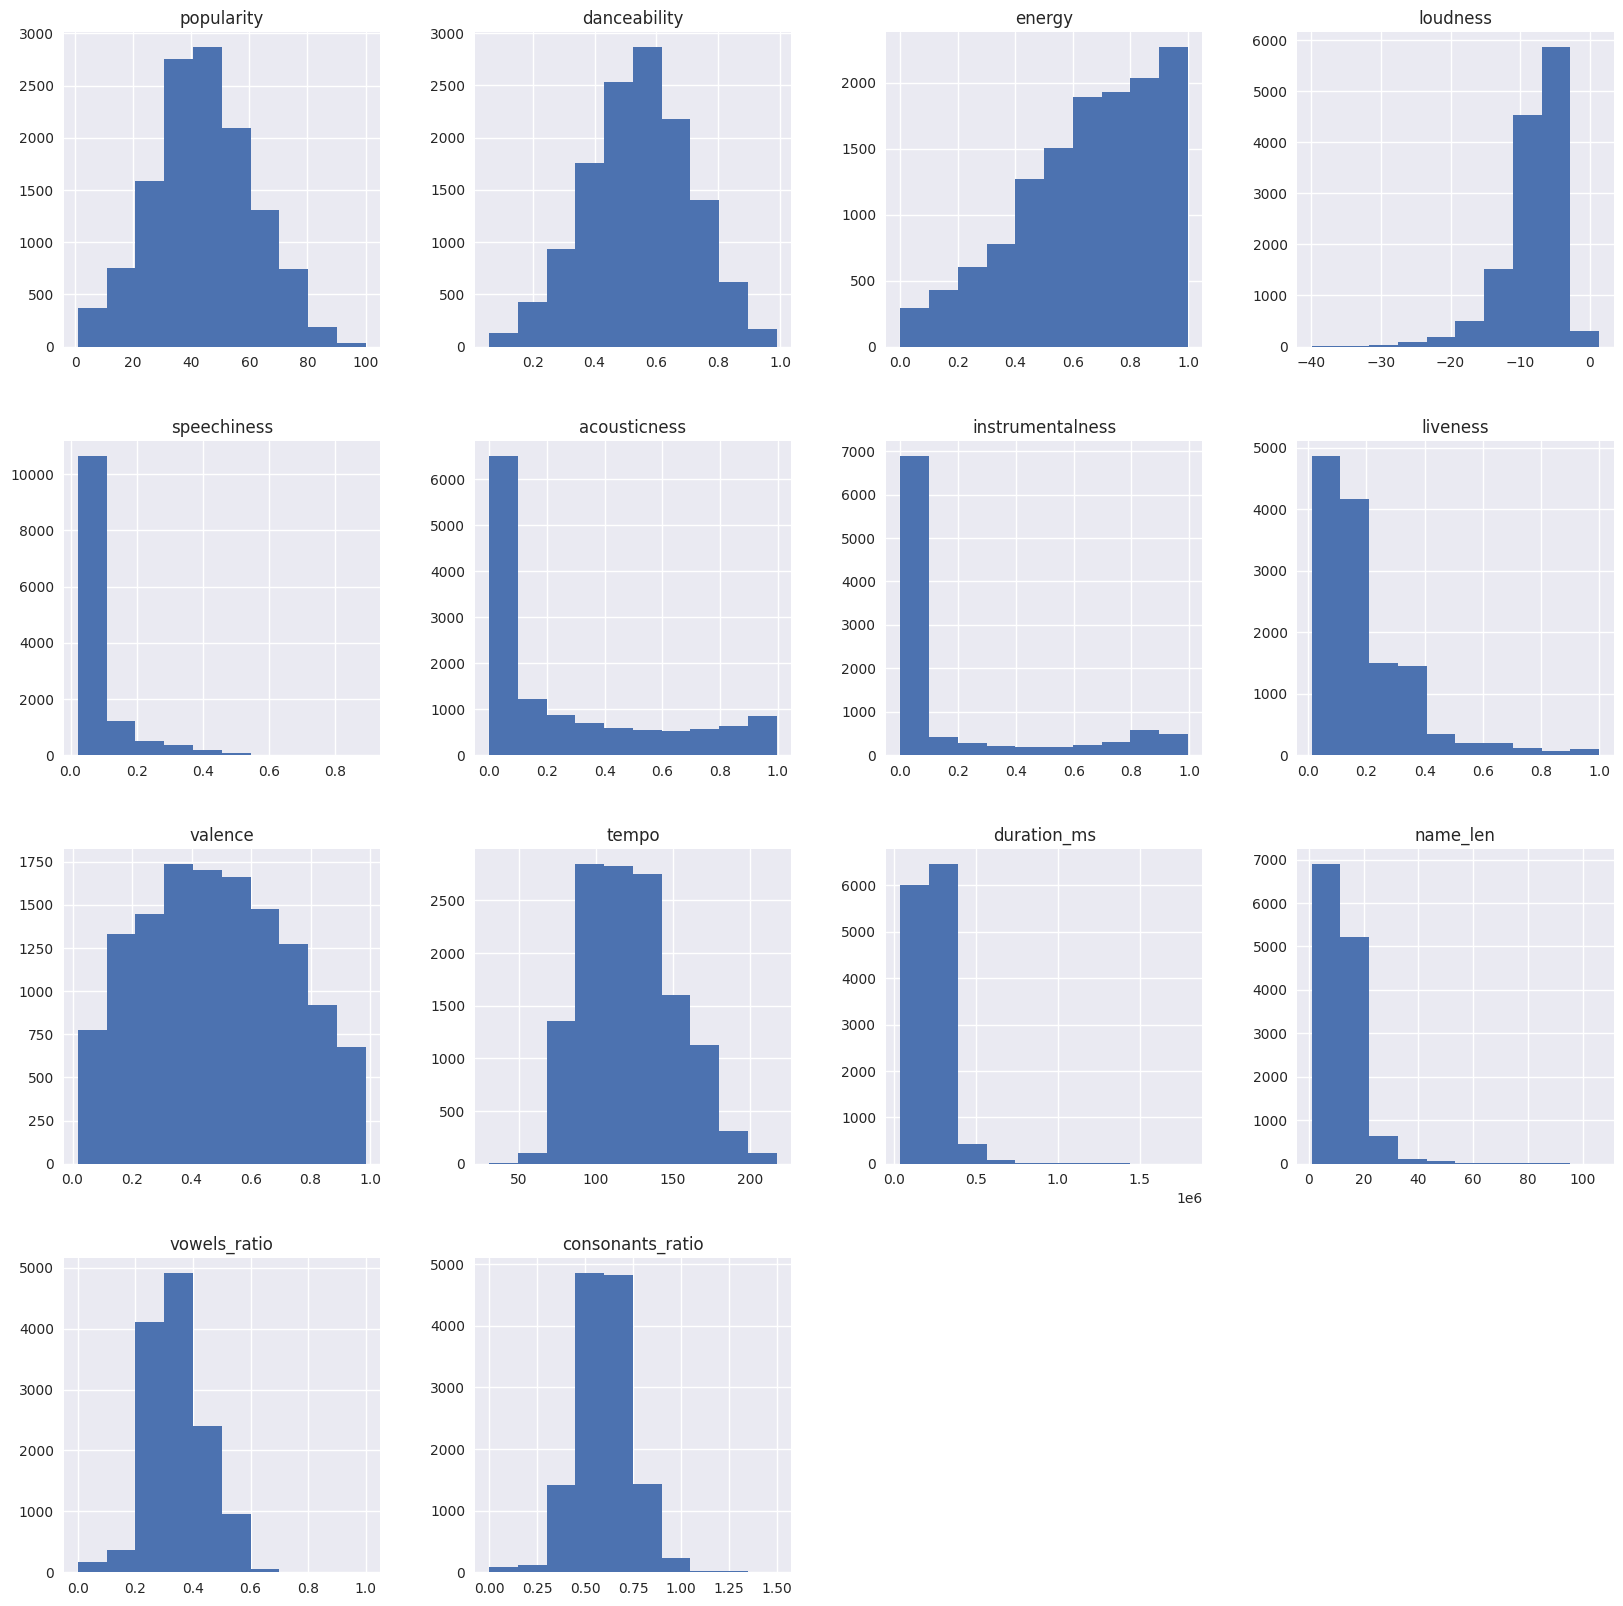

In [40]:
# for popularity, danceability, energy, loudness,
# valence, tempo, vowels_ratio, consonants_ratio - StandardScaler

# for speechiness, acousticness, instrumentalness,
# liveness, duration_ms, name_len - logscale
with plt.style.context("seaborn-v0_8"):
    df.loc[x_train.index].hist(figsize=(20, 20))

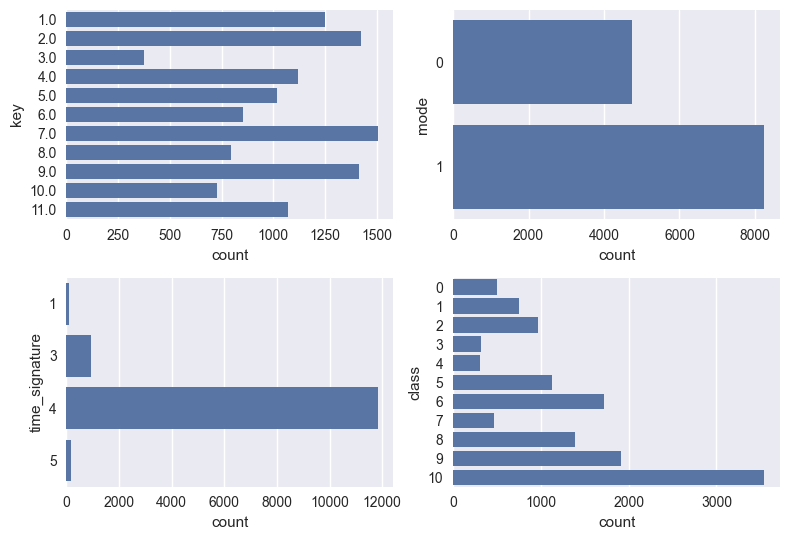

In [239]:
with plt.style.context("seaborn-v0_8"):
    _, axs = plt.subplots(2, 2)
    for i, col in enumerate(df.loc[x_train.index].select_dtypes("category").columns):
        sns.countplot(df.loc[x_train.index, col], ax=axs[0 if i < 2 else 1, i % 2])
    plt.tight_layout()
    plt.show();

<Axes: >

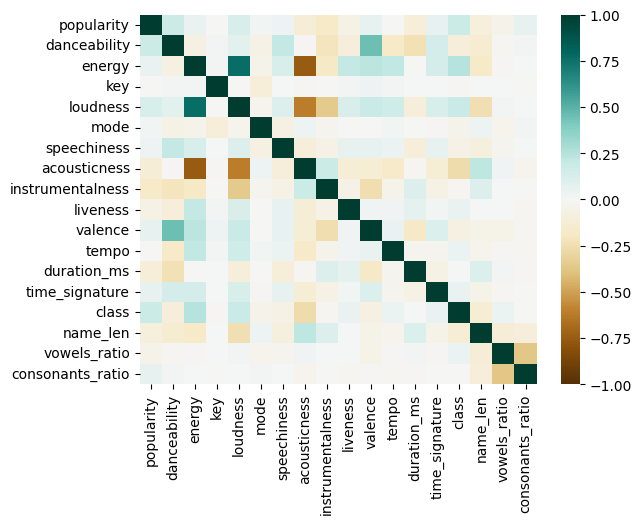

In [35]:
# there are linearly correlated features such
# as acousticness/energy, loudness/energy, acousticness/loudness.
# there aren't any considerably correlated feature to class variable
sns.heatmap(
    df.loc[x_train.index].drop(["artist"], axis=1).corr(),
    cmap="BrBG", vmin=-1.
)

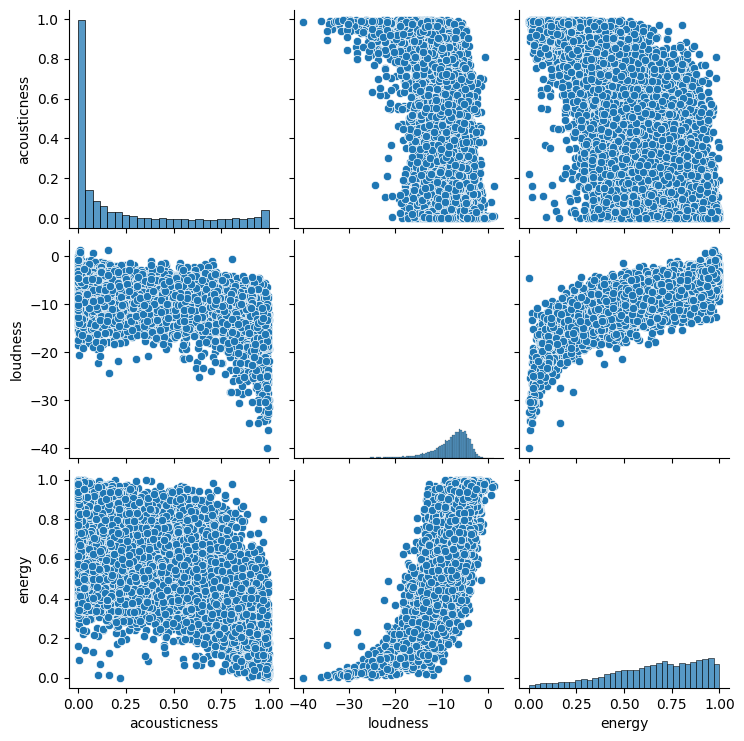

In [36]:
# loudness and acousticness distribution has linear dependency
# may be nonlinear such as logarithmic
sns.pairplot(df.loc[x_train.index, ["acousticness", "loudness", "energy"]])

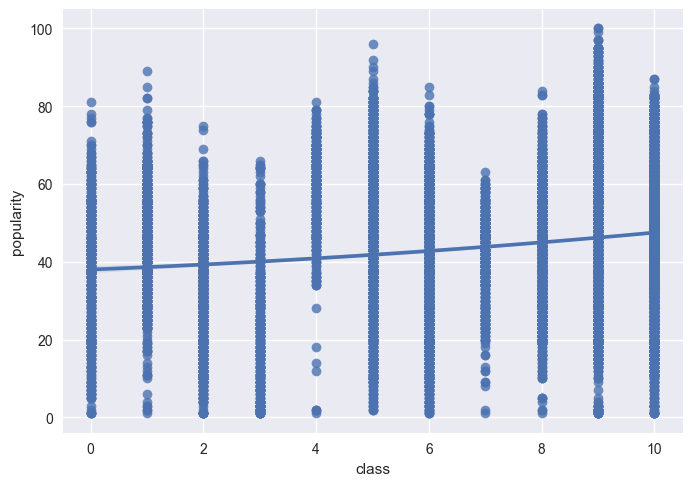

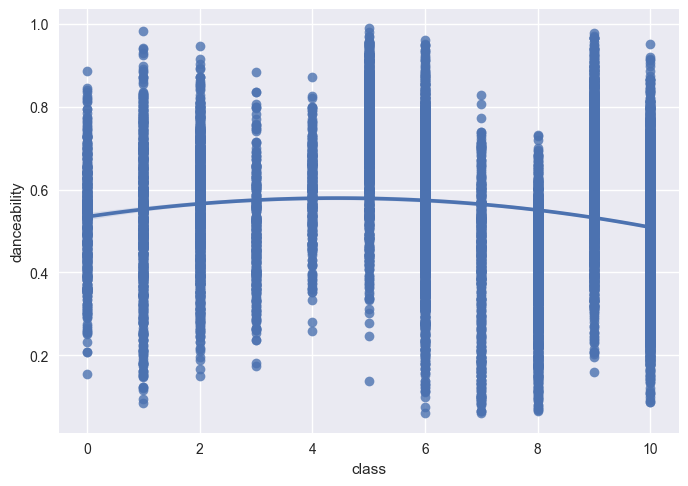

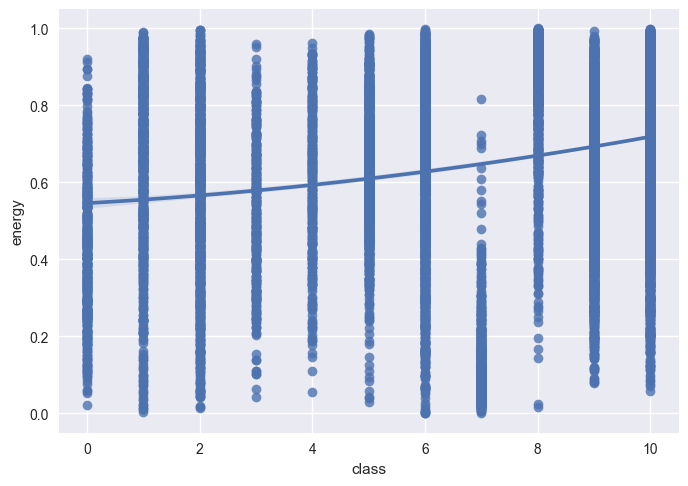

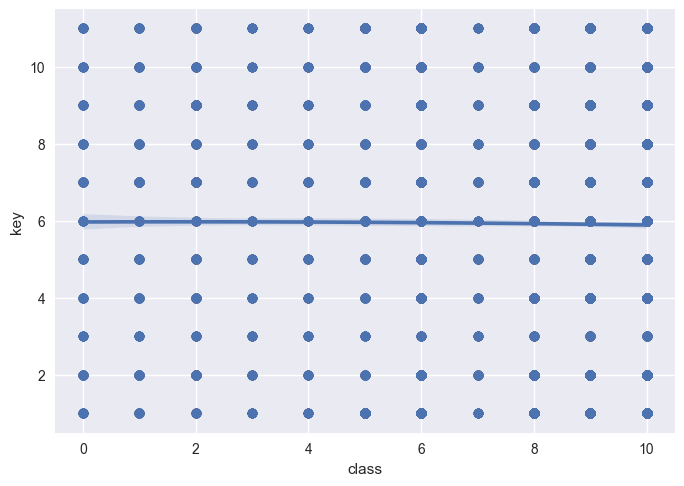

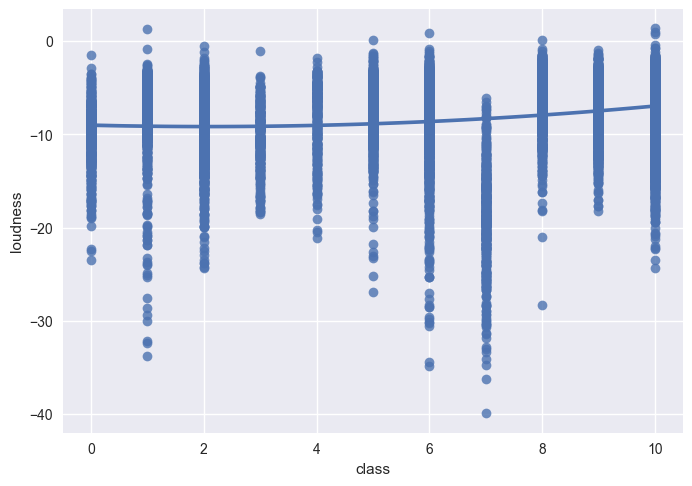

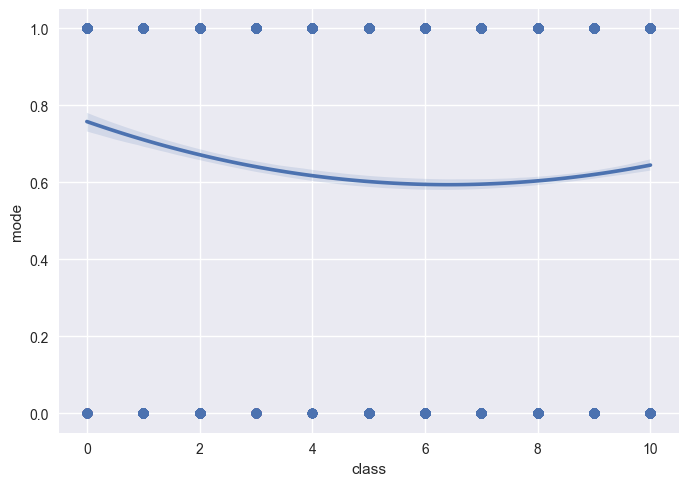

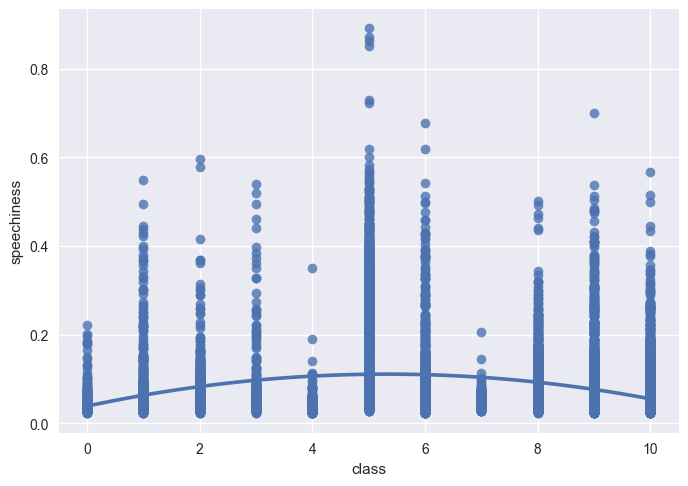

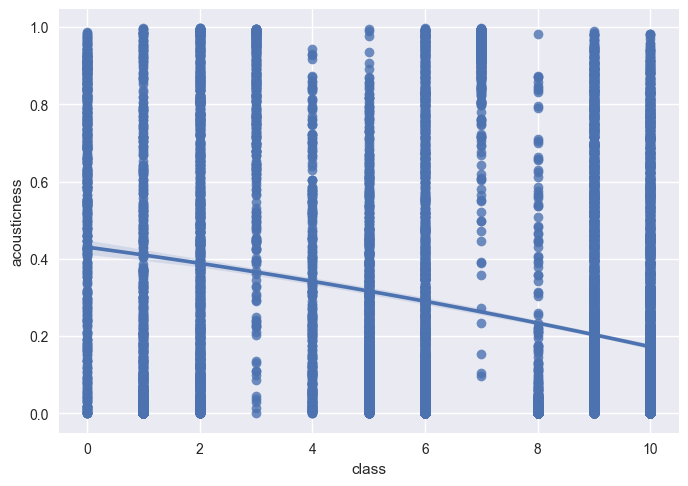

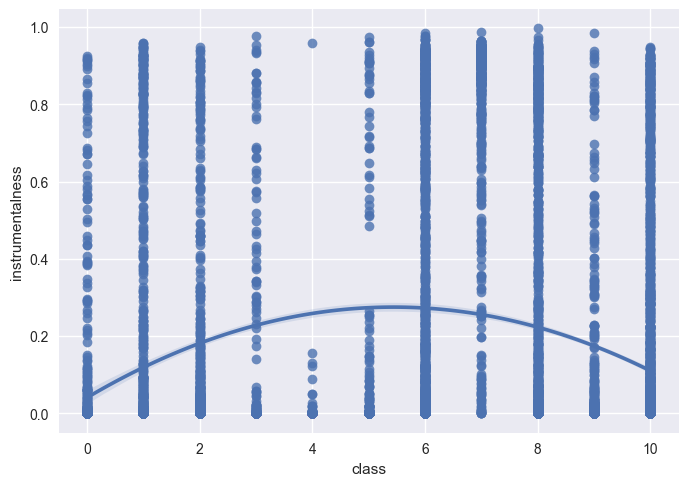

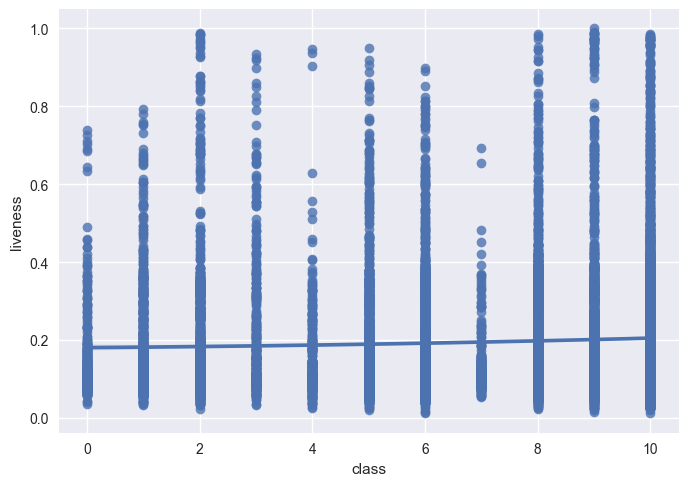

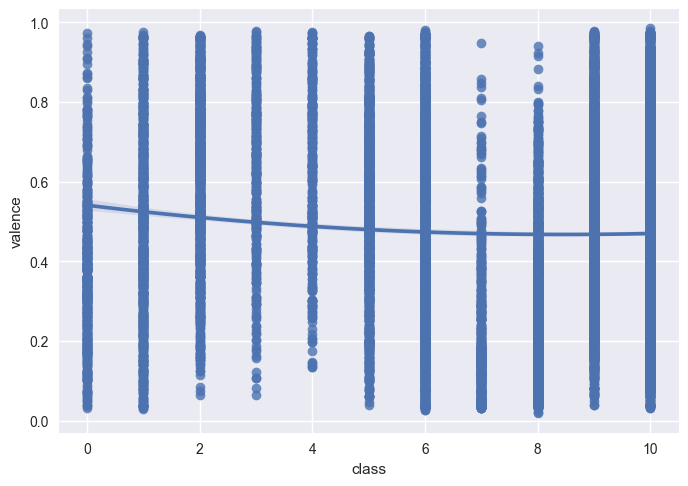

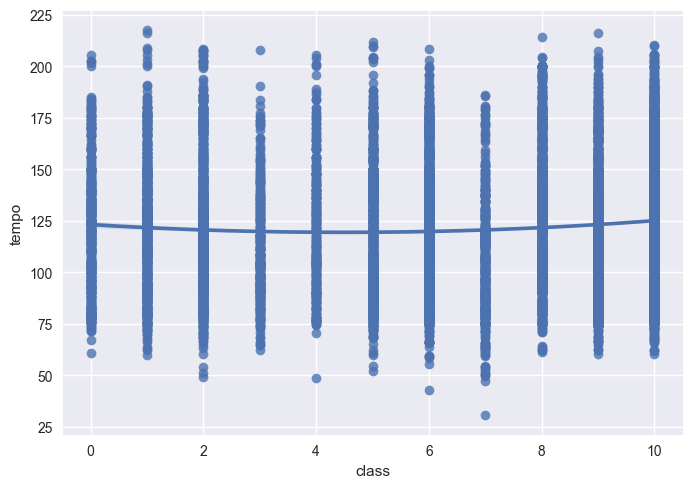

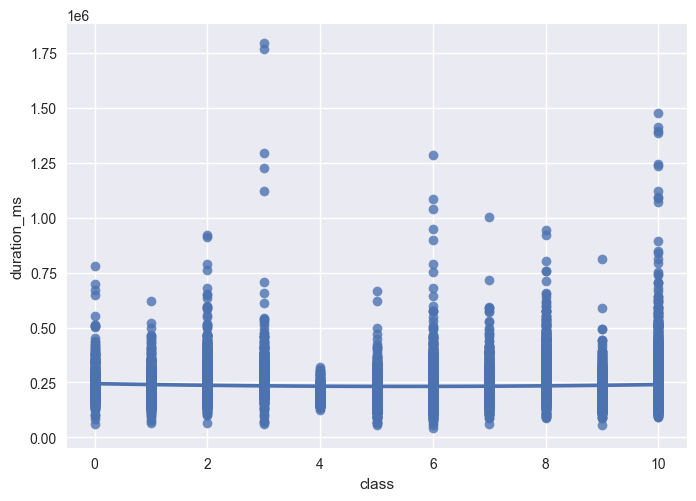

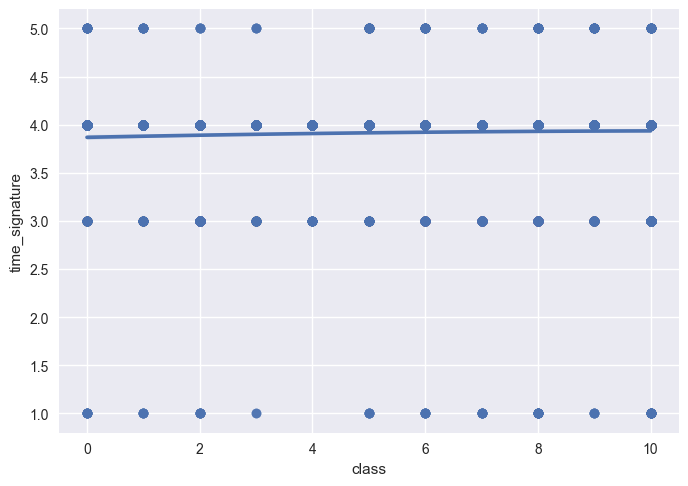

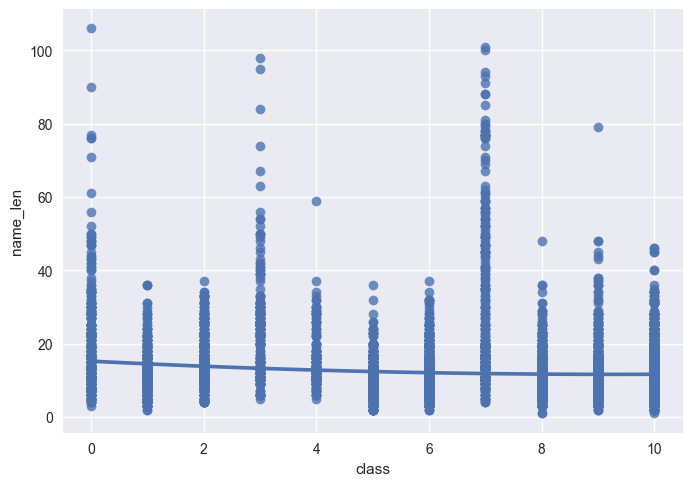

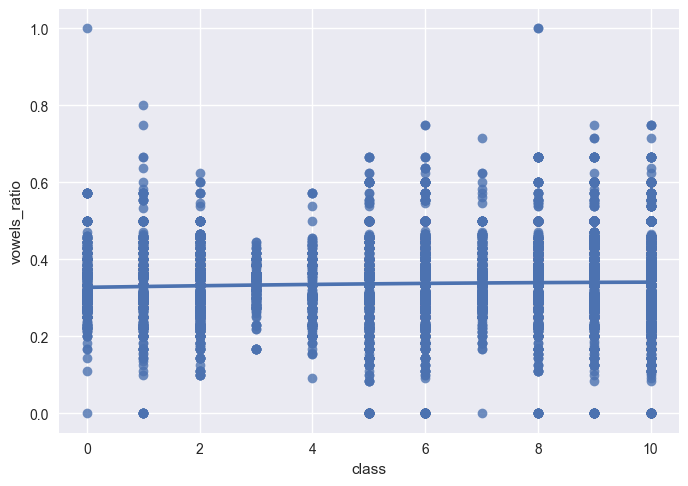

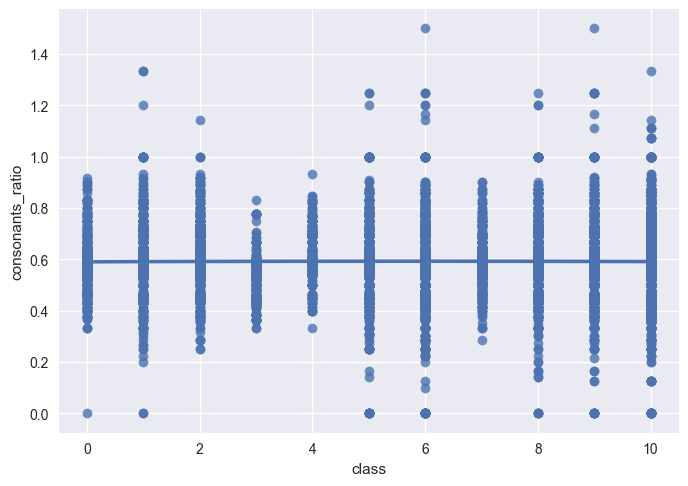

In [80]:
# it is difficult to select any pattern for each feature
# but some feature has a few information about class distribution
# like speechiness and info about artist name
with plt.style.context("seaborn-v0_8"):
    for col in x_train.columns:
        if col in categ_cols:
            sns.regplot(x=y_train.cat.as_ordered(), y=x_train.loc[:, col].cat.as_ordered(), order=2)
        else:
            sns.regplot(x=y_train.cat.as_ordered(), y=x_train.loc[:, col], order=2)
        plt.show();

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


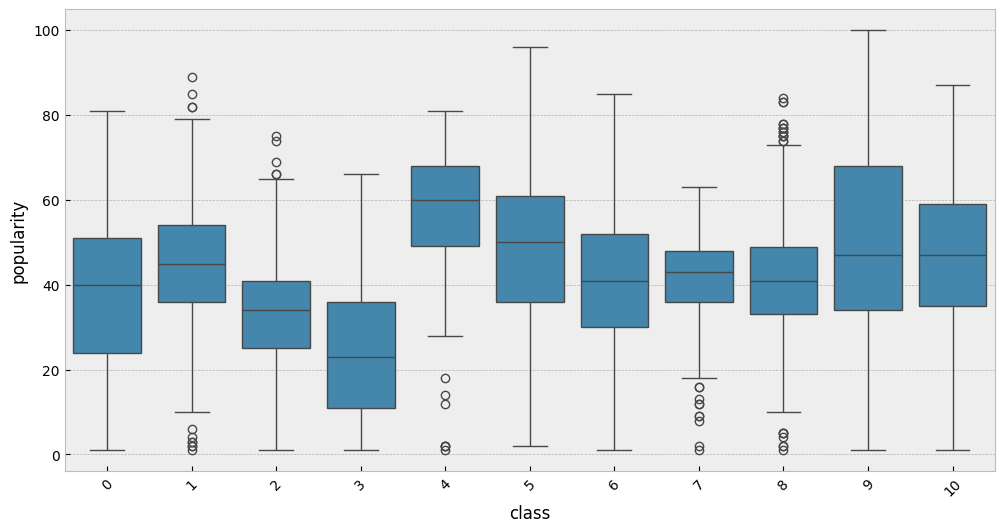

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


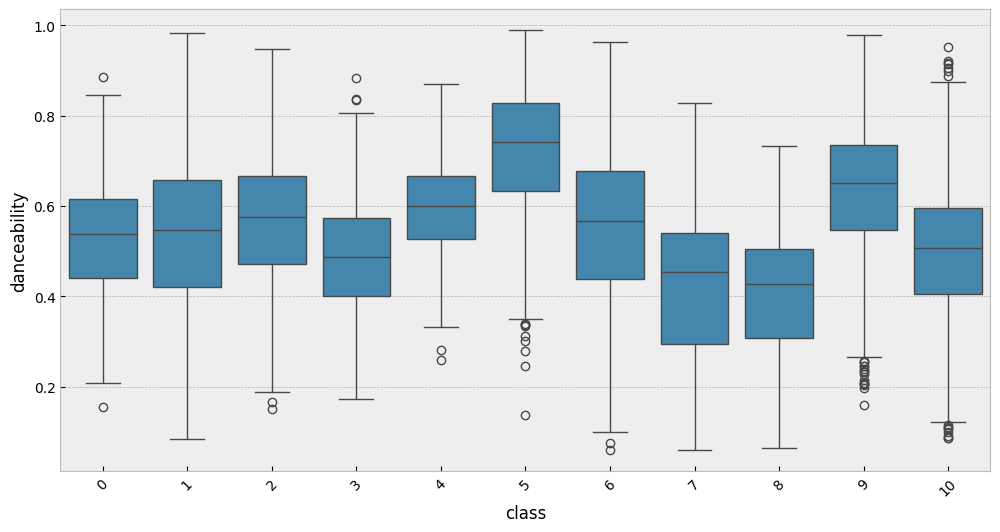

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


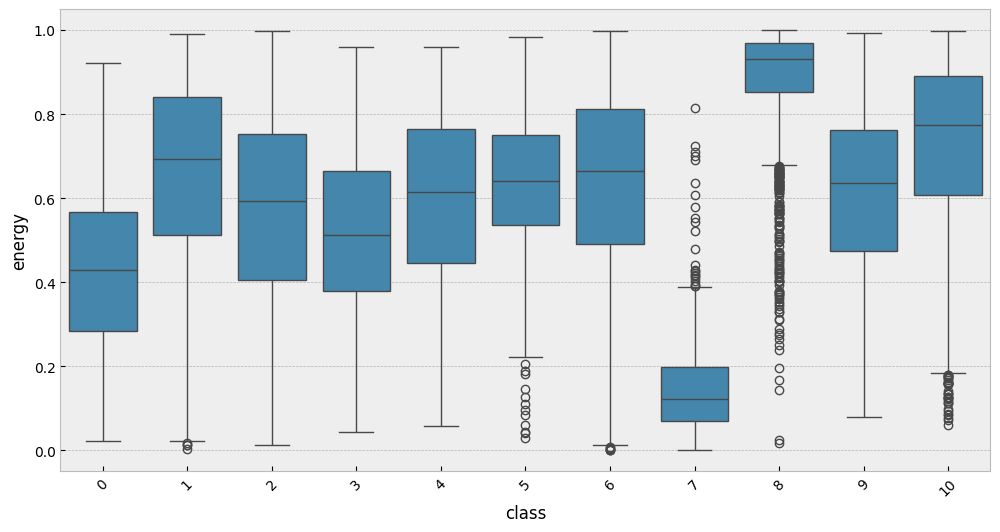

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


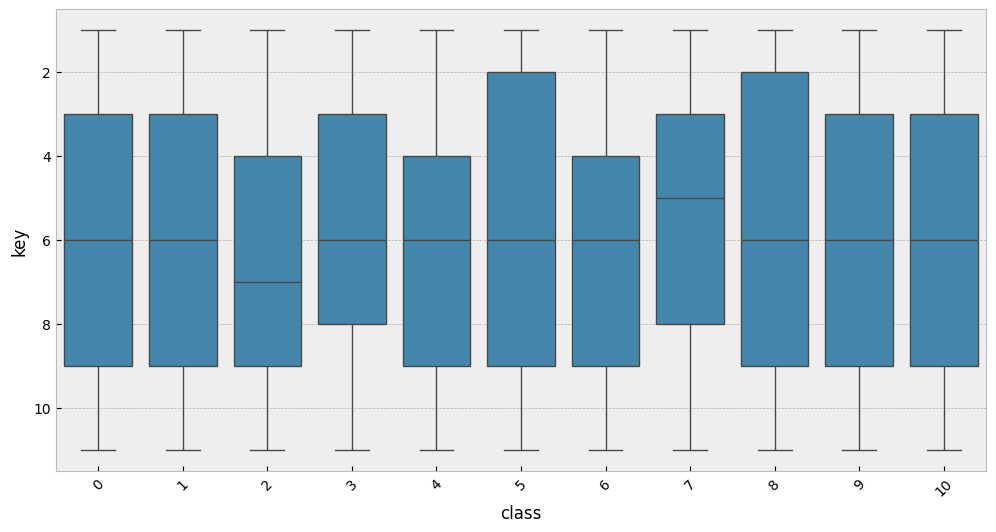

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


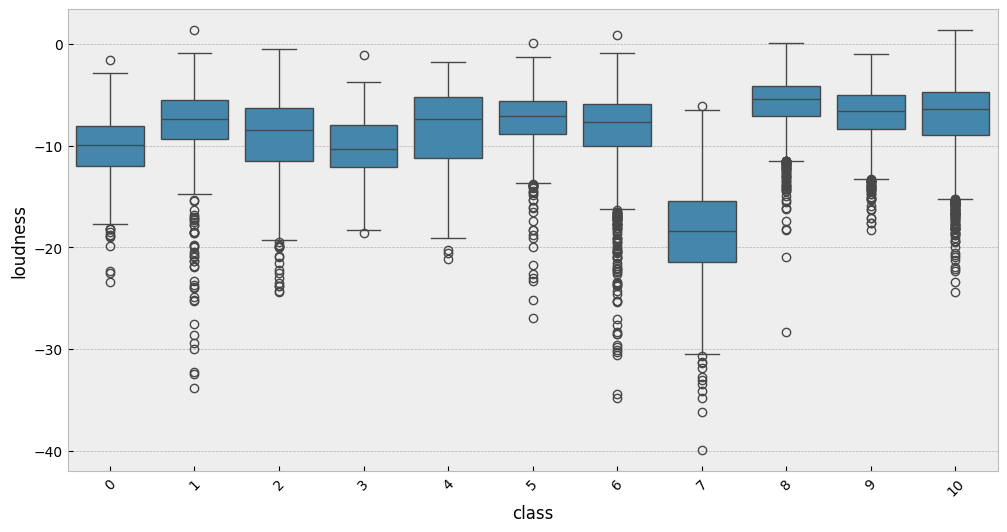

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


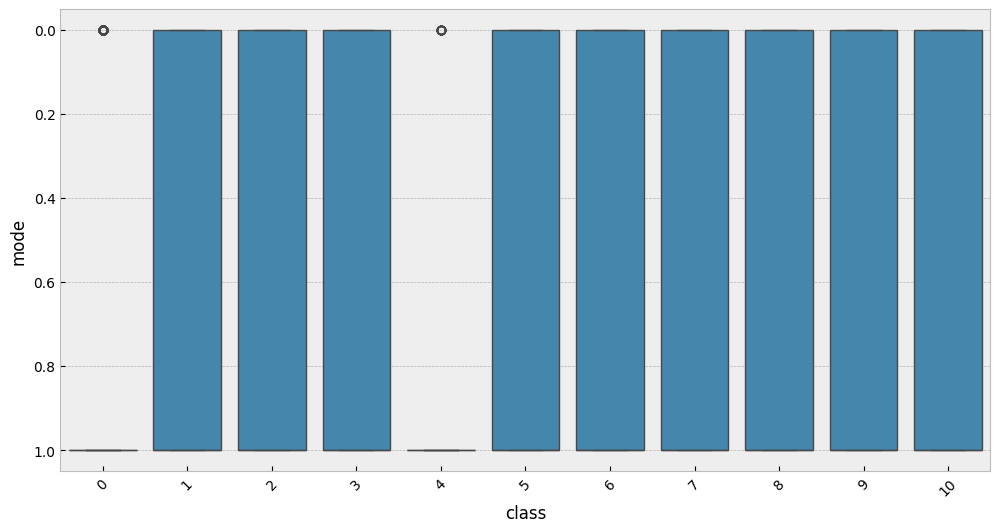

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


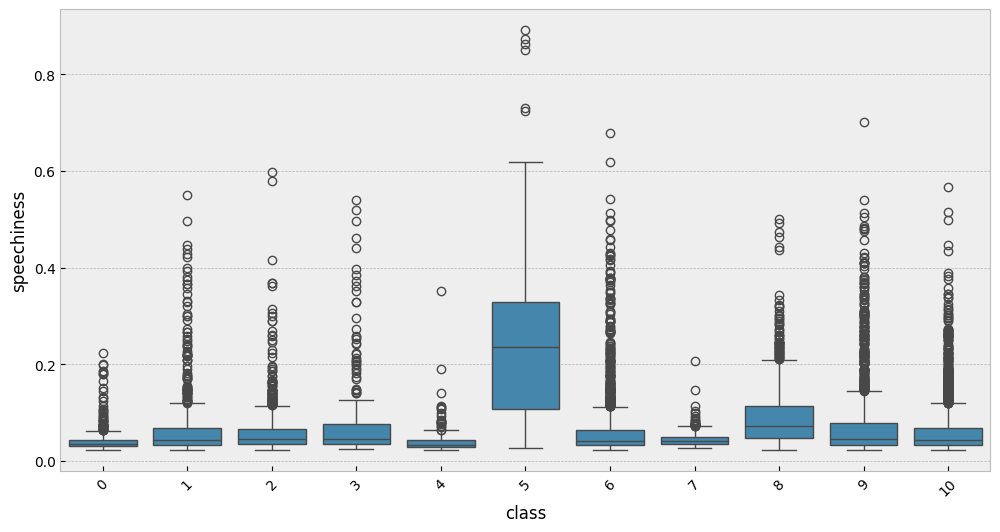

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


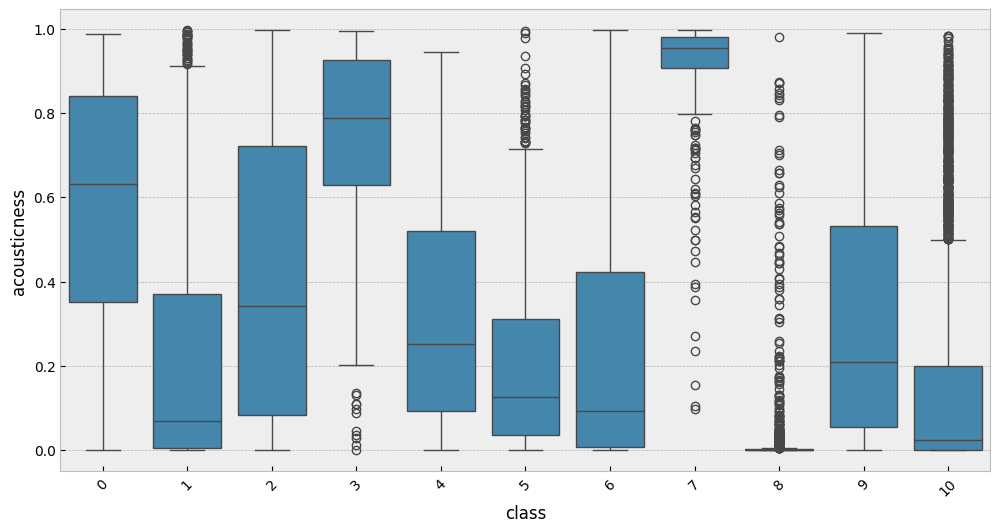

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


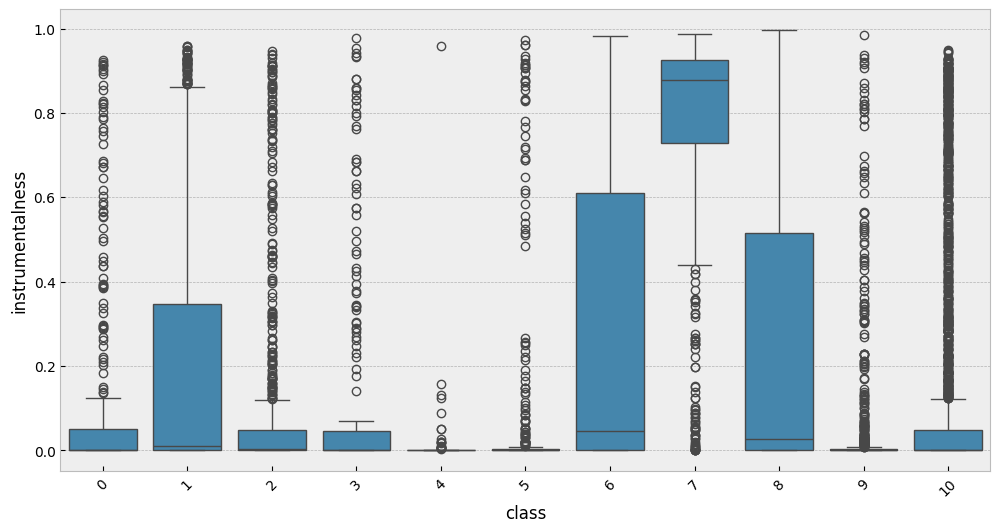

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


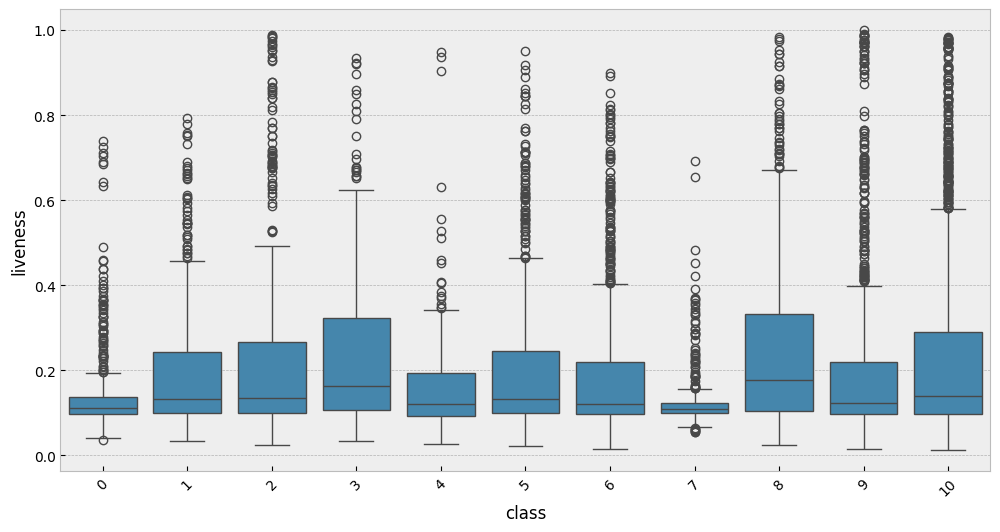

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


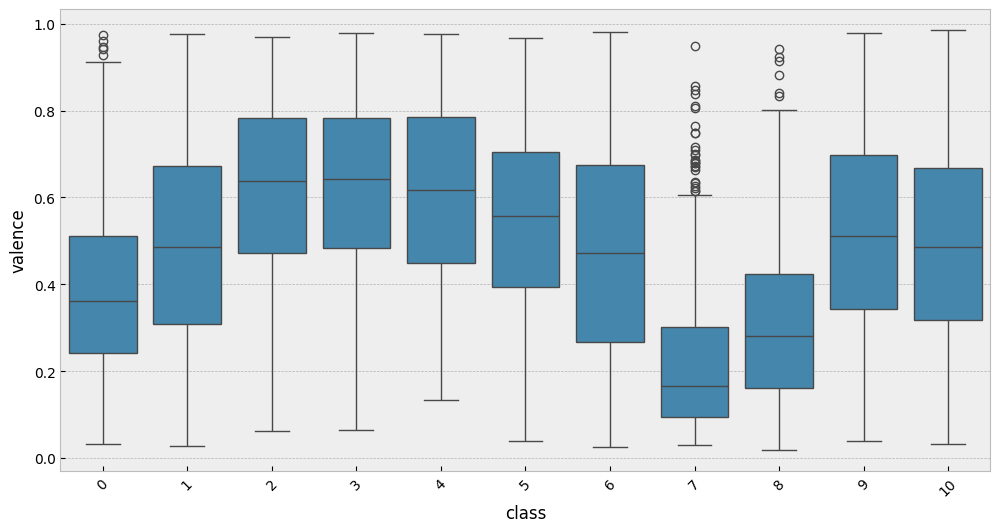

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


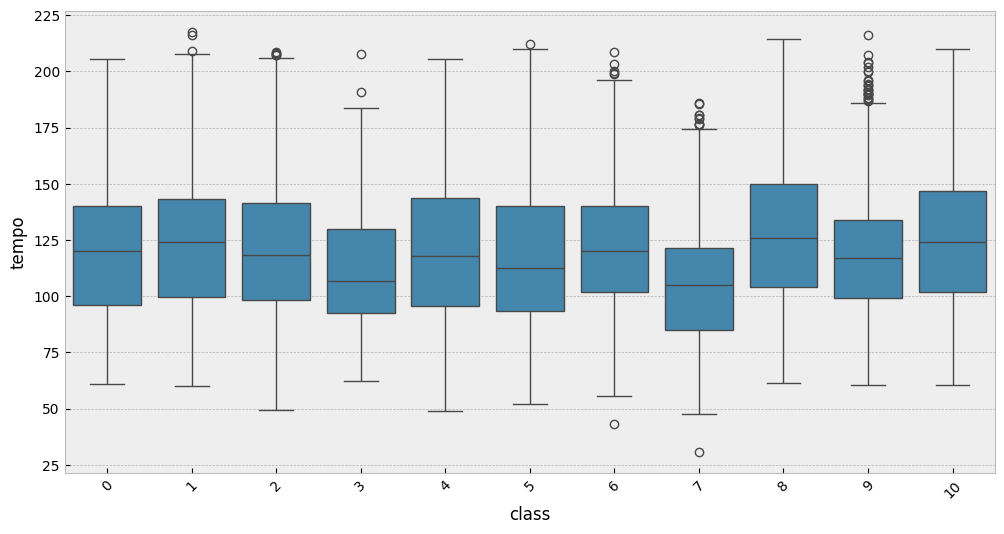

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


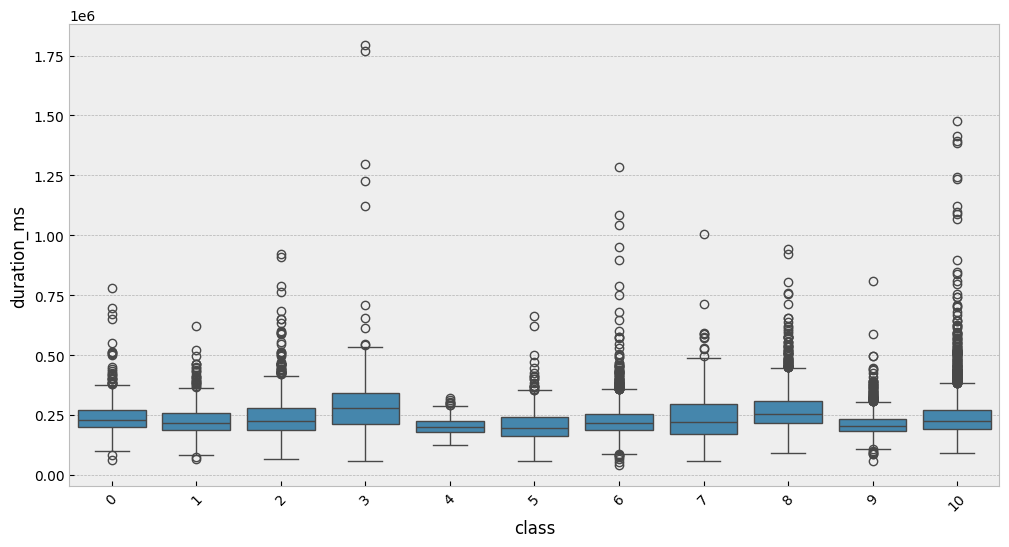

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


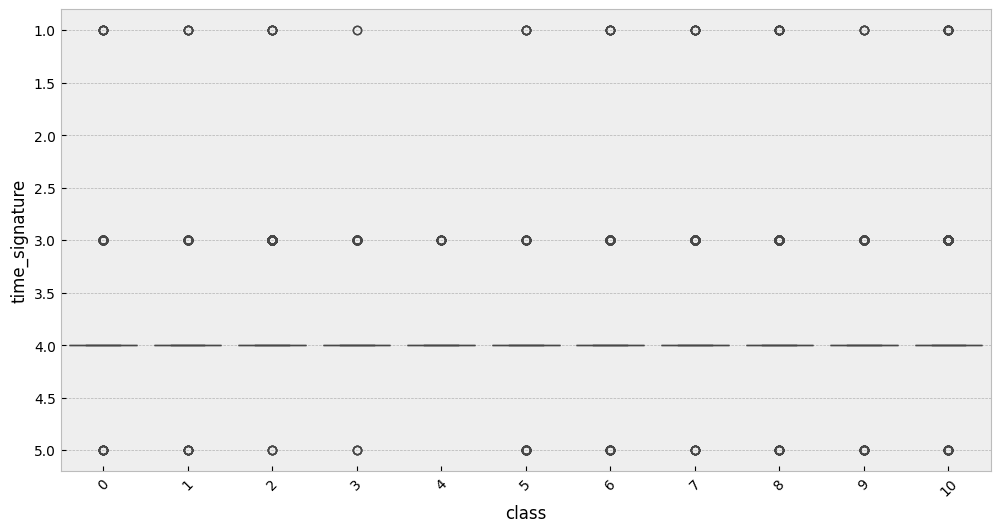

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


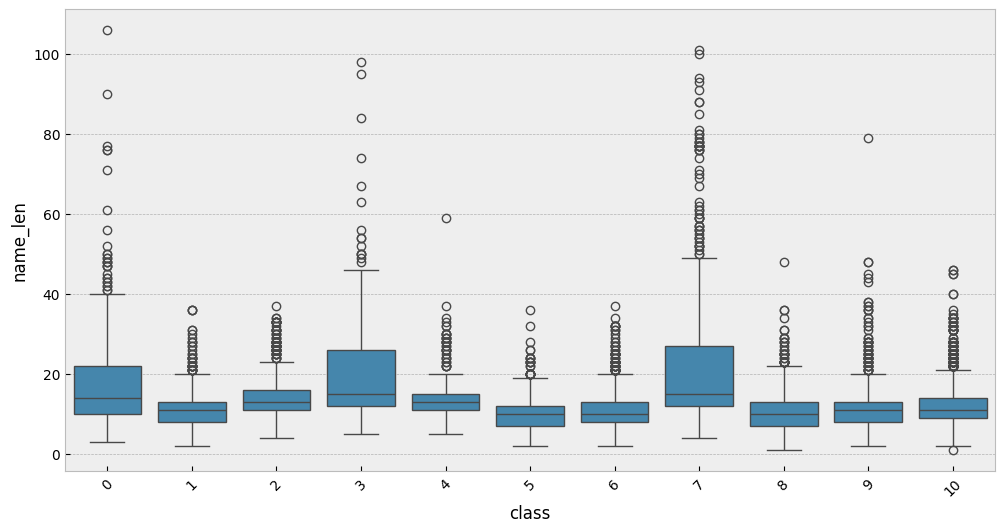

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


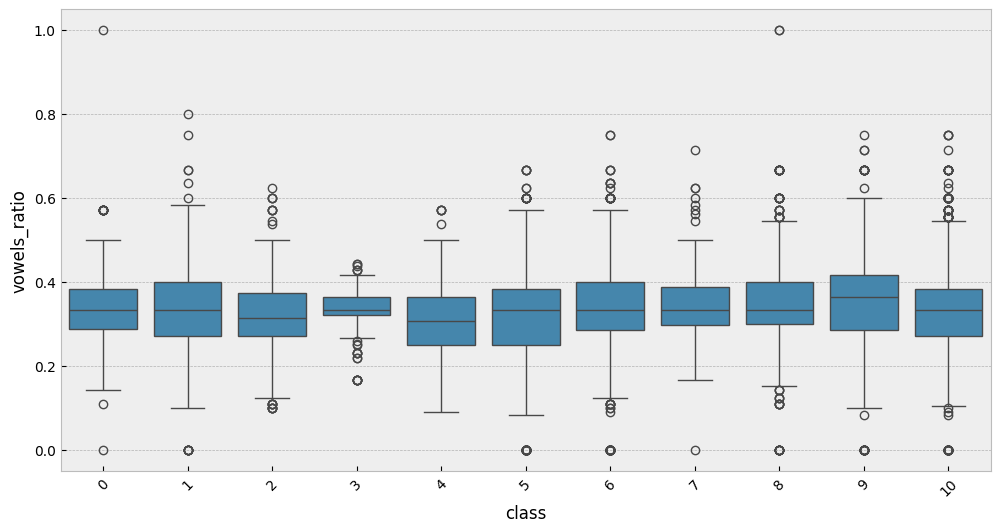

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


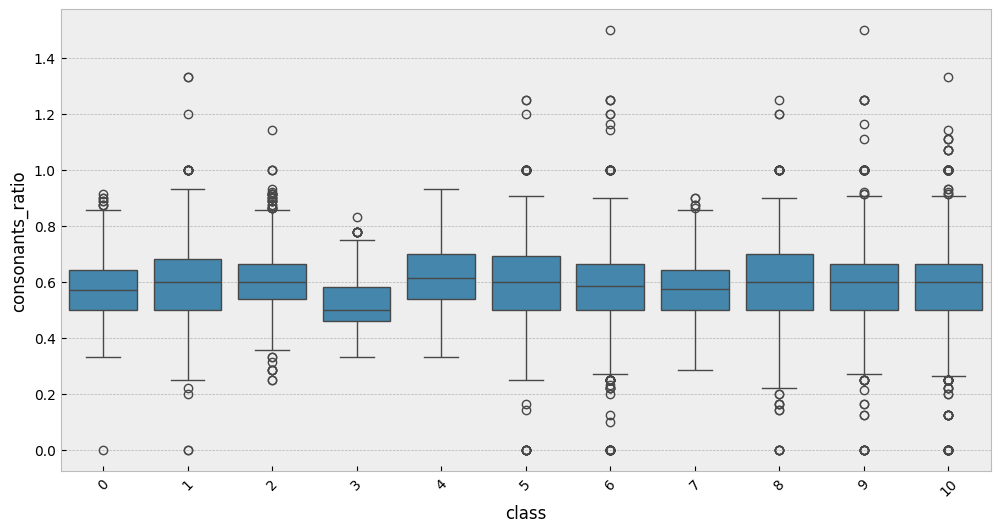

In [81]:
with plt.style.context("bmh"):
    for col in x_train.columns:
        plt.figure(figsize = (12, 6))
        ax = sns.boxplot(x=y_train, y=x_train.loc[:, col])
        plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
        plt.xticks(rotation=45)
        plt.show();

## Feature selection

In [56]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(["class", "artist"], axis=1), df.loc[:, "class"], test_size=0.2,
    random_state=17, shuffle=True, stratify=df.loc[:, "class"]
)
numeric_cols = x_train.select_dtypes(exclude=["category", "object"]).columns.to_list()
categ_cols = x_train.select_dtypes(include=["category", "object"]).columns.to_list()

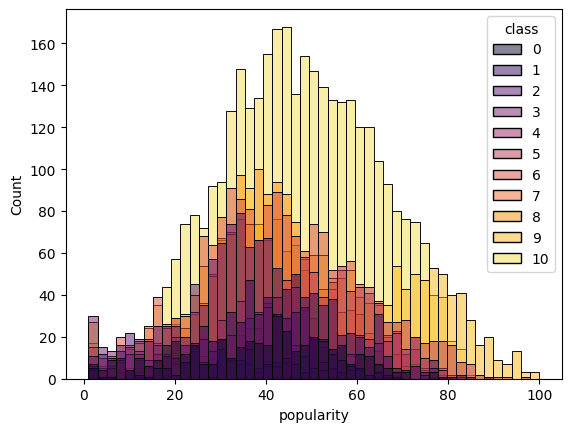

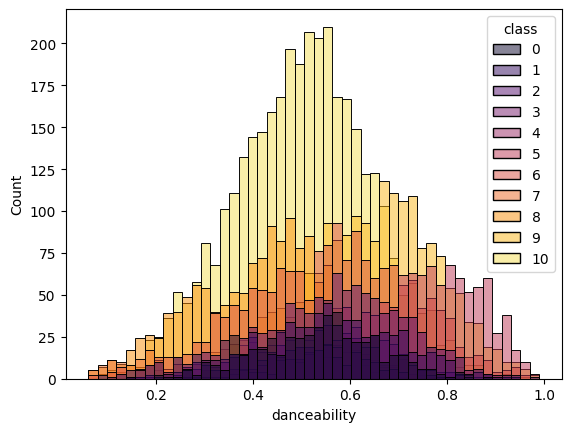

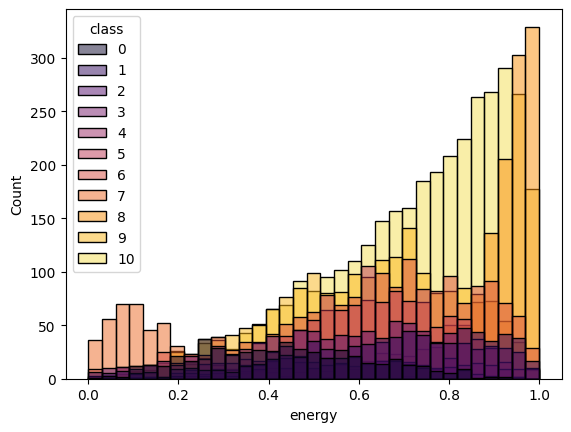

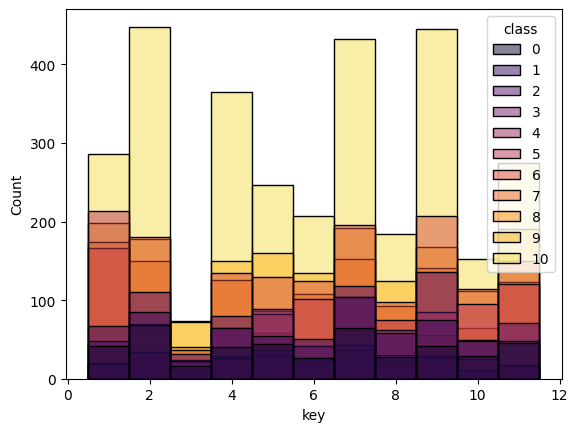

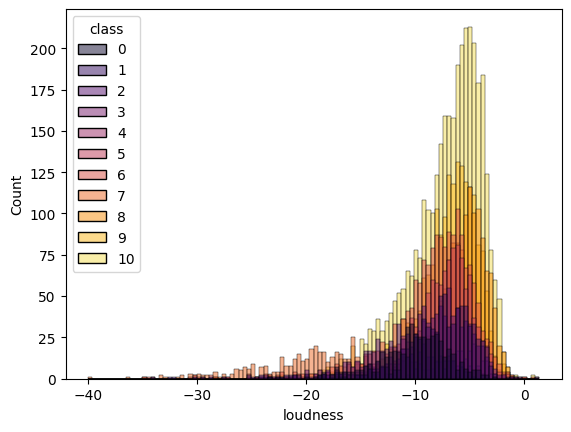

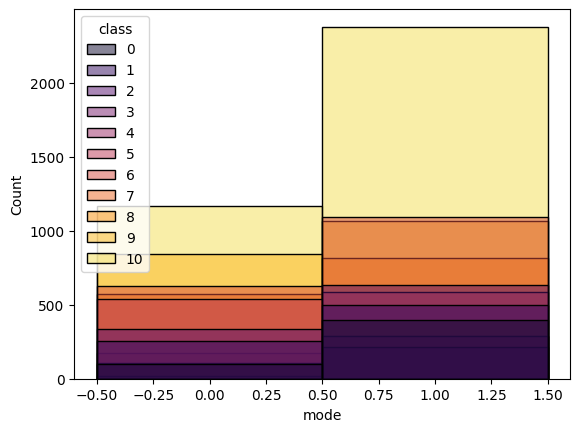

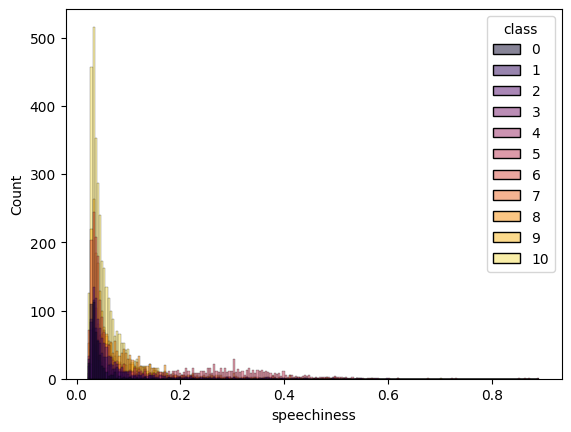

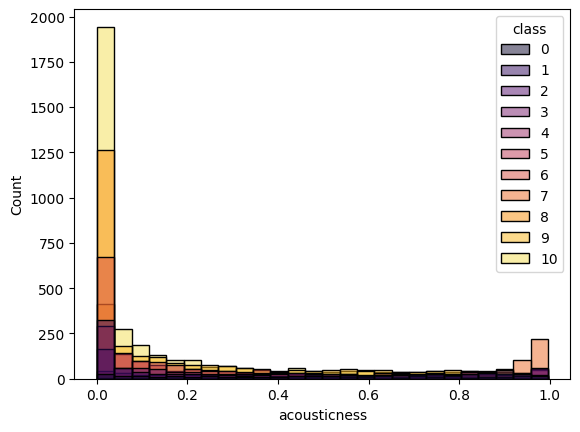

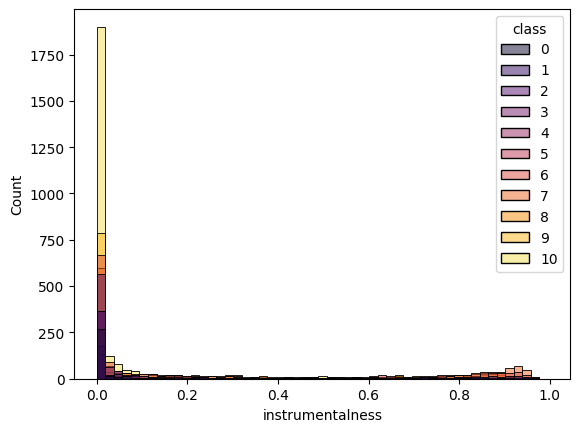

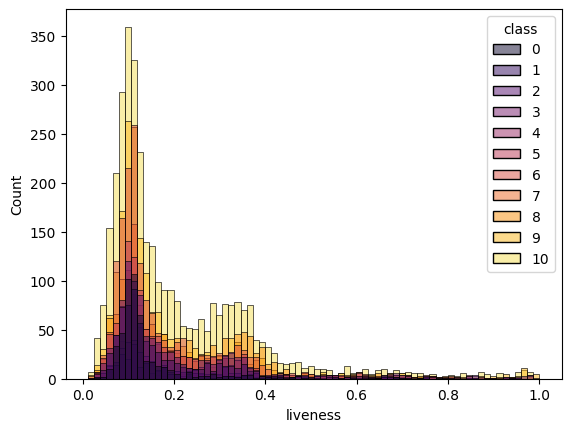

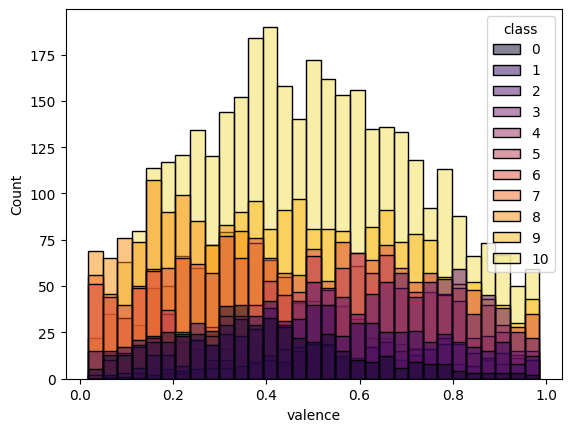

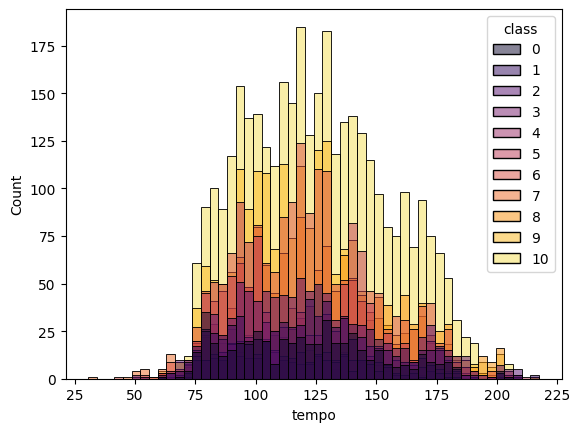

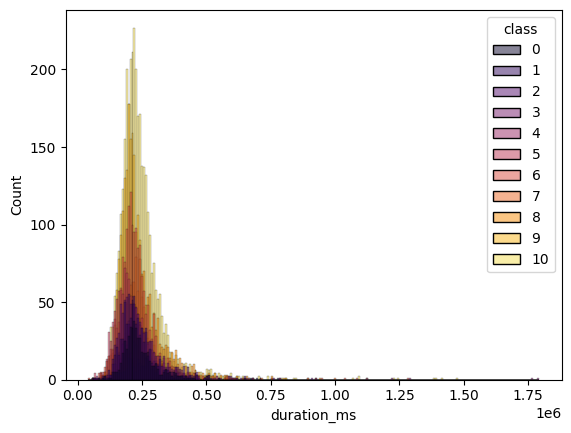

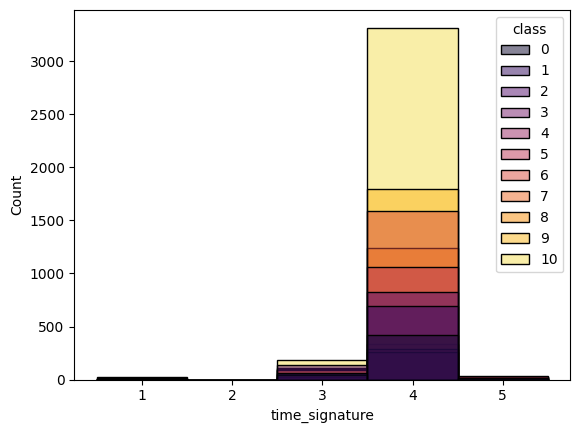

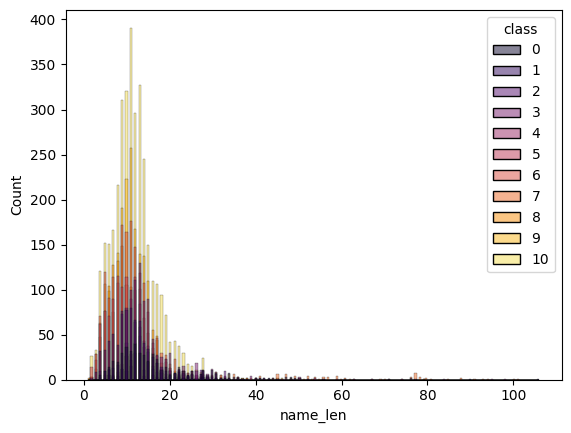

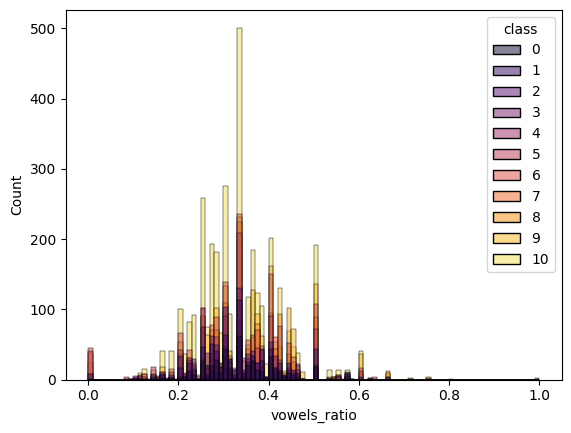

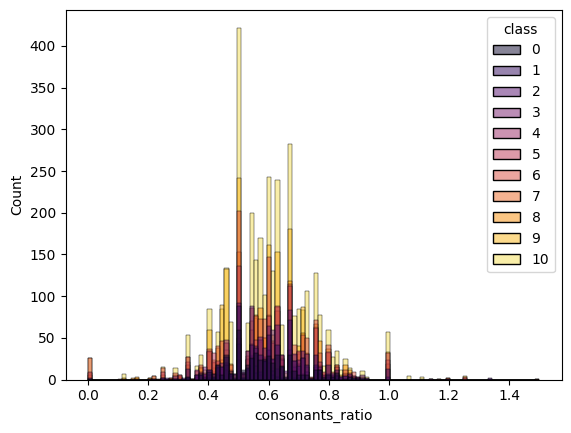

In [59]:
for col in x_train.columns:
    sns.histplot(
        data=pd.concat([x_train, y_train], axis=1),
        x=col, hue="class", palette="inferno"
    )
    plt.show();

C:\Users\lev-m\AppData\Local\Temp\ipykernel_1424\2807981383.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=x_train.columns.to_list(), x=f_stat, orient="y", palette="husl")


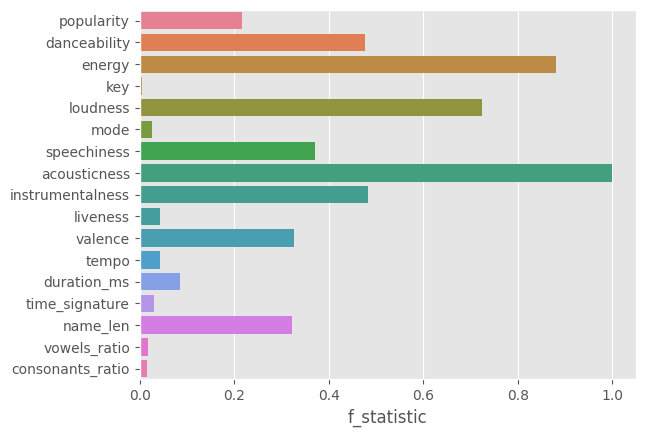

In [66]:
# dancebality, energy, loudness, instrumentalness, acousticness
mask = x_train.notna().all(axis=1)
f_stat, p_val = f_classif(x_train.loc[mask], y_train.loc[mask])
f_stat /= np.max(f_stat)
with plt.style.context("ggplot"):
    sns.barplot(y=x_train.columns.to_list(), x=f_stat, orient="y", palette="husl")
    plt.xlabel("f_statistic")
    plt.show();

C:\Users\lev-m\AppData\Local\Temp\ipykernel_1424\3244732317.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=x_train.columns.to_list(), x=f_stat, orient="y", palette="husl")


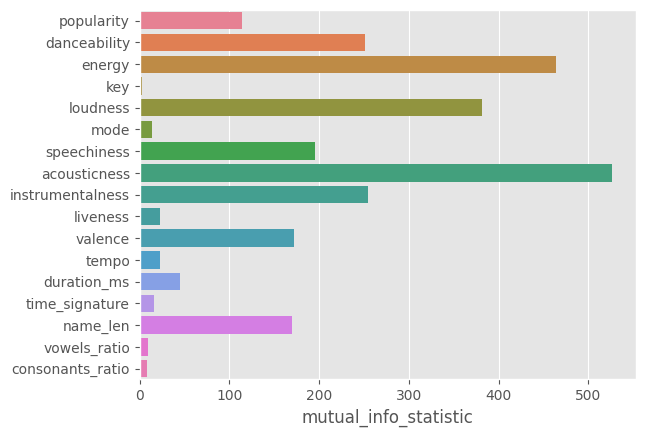

In [65]:
# equal to f-test
mask = x_train.notna().all(axis=1)
mi_stat = mutual_info_classif(
    x_train.loc[mask], y_train.loc[mask],
    n_neighbors=7, random_state=17
)
with plt.style.context("ggplot"):
    sns.barplot(y=x_train.columns.to_list(), x=f_stat, orient="y", palette="husl")
    plt.xlabel("mutual_info_statistic")
    plt.show();

## Remove uninformative columns

In [95]:
df.drop(columns=[
    "artist", "key", "mode", "liveness",
    "tempo", "time_signature",
    "vowels_ratio", "consonants_ratio"
]).to_csv("data_files/preprocessed.csv", index=False)

# Train models

In [ ]:
# split data into train val and test folds with ratio 80:20
df = pd.read_csv("data_files/preprocessed.csv")
x_train, x_test, y_train, y_test = train_test_split(
    df.drop("class", axis=1), df.loc[:, "class"], test_size=0.2,
    random_state=17, shuffle=True, stratify=df.loc[:, "class"]
)
iforest = IsolationForest(n_estimators=400, contamination=0.003, random_state=17)
is_normal = iforest.fit_predict(x_train) == 1
x_train = x_train.loc[is_normal]
y_train = y_train.loc[is_normal]
numeric_cols = x_train.select_dtypes(exclude=["category", "object"]).columns.to_list()
categ_cols = x_train.select_dtypes(include=["category", "object"]).columns.to_list()

In [248]:
search_svm = GridSearchCV(
    BaseClassifier(
        SVC(random_state=17, max_iter=1000, probability=True),
        numeric_cols, categ_cols
    ), {
        "C": [0.1, 1., 10, 100],
        "kernel": ["poly", "rbf", "sigmoid", "linear"]
    }, scoring="roc_auc_ovr", n_jobs=-1, refit=True, cv=5,
    error_score="raise", verbose=11
)
search_svm.fit(x_train, y_train)
print(
    f"best params: {search_svm.best_params_}",
    f"CV ROC AUC: {search_svm.best_score_}",
    sep="\n"
)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


best params: {'C': 10, 'kernel': 'rbf'}
CV ROC AUC: 0.8568354445999166


c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [246]:
search_knn = GridSearchCV(
    BaseClassifier(
        KNeighborsClassifier(), numeric_cols, categ_cols,
        True, True, True
    ), {
        "n_neighbors": np.arange(3, 102, 2),
        "p": [1, 2, 3],
        "weights": ["distance", "uniform"]
    }, scoring="roc_auc_ovr", n_jobs=-1, refit=True, cv=5,
    error_score="raise", verbose=11
)
search_knn.fit(x_train, y_train)
print(
    f"best params: {search_knn.best_params_}",
    f"CV ROC AUC: {search_knn.best_score_}",
    sep="\n"
)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


best params: {'n_neighbors': np.int64(101), 'p': 1, 'weights': 'distance'}
CV ROC AUC: 0.8459792392997834


50
100
150
200
250
300
350
400
450
500
550
600


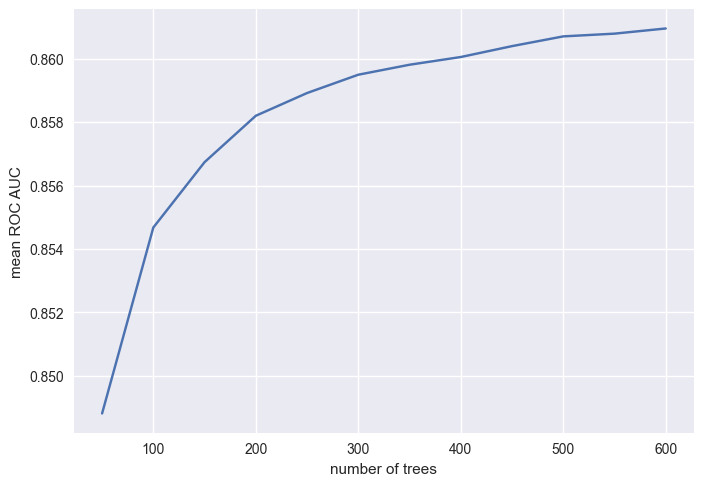

In [ ]:
# selection of optimal number of decision trees
m = []
for ne in range(50, 610, 50):
    print(ne)
    m.append(cross_val_score(
        BaseClassifier(
            RandomForestClassifier(random_state=17, n_estimators=ne, max_features=0.7),
            numeric_cols, categ_cols,
            True, True, True
        ), x_train, y_train, scoring="roc_auc_ovr", n_jobs=-1
    ).mean())
with plt.style.context("seaborn-v0_8"):
    sns.lineplot(x=np.arange(50, 610, 50), y=m)
    plt.xlabel("number of trees")
    plt.ylabel("mean ROC AUC")
    plt.show();

In [247]:
search_rf = GridSearchCV(
    BaseClassifier(
        RandomForestClassifier(random_state=17, n_estimators=300), numeric_cols, categ_cols,
        True, True, True
    ), {
        "criterion": ["gini", "entropy"],
        "max_features": ["sqrt", "log2", 0.5, 0.7],
        "min_samples_leaf": [1, 2, 3, 4, 5]
    }, scoring="roc_auc_ovr", n_jobs=-1, refit=True, cv=5,
    error_score="raise", verbose=11
)
search_rf.fit(x_train, y_train)
print(
    f"best params: {search_rf.best_params_}",
    f"CV ROC AUC: {search_rf.best_score_}",
    sep="\n"
)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


best params: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 4}
CV ROC AUC: 0.8730738470008017


# Validate

In [3]:
# too dificult to predict class 1 and 6
df = pd.read_csv("data_files/preprocessed.csv")
x_train, x_test, y_train, y_test = train_test_split(
    df.drop("class", axis=1), df.loc[:, "class"], test_size=0.2,
    random_state=17, shuffle=True, stratify=df.loc[:, "class"]
)
iforest = IsolationForest(n_estimators=400, contamination=0.003, random_state=17)
is_normal = iforest.fit_predict(x_train) == 1
x_train = x_train.loc[is_normal]
y_train = y_train.loc[is_normal]
numeric_cols = x_train.select_dtypes(exclude=["category", "object"]).columns.to_list()
categ_cols = x_train.select_dtypes(include=["category", "object"]).columns.to_list()
preds = {}
models = {
    "svm": BaseClassifier(
        SVC(
            C=10., kernel="rbf", random_state=17,
            max_iter=-1, probability=True
        ),
        numeric_cols, categ_cols
    ),
    "knn": BaseClassifier(
        KNeighborsClassifier(n_neighbors=101, p=1, weights="distance"),
        numeric_cols, categ_cols
    ),
    "rf": BaseClassifier(
        RandomForestClassifier(
            random_state=17, n_estimators=300, criterion="gini",
            max_features="sqrt", min_samples_leaf=4
        ),
        numeric_cols, categ_cols,
    )
}
for model in models:
    models[model].fit(x_train, y_train)
    preds[model] = {}
    preds[model]["proba"] = models[model].predict_proba(x_test)
    preds[model]["label"] = models[model].predict(x_test)
    print(
        model.upper(),
        f"ROC AUC: {roc_auc_score(y_test, preds[model]["proba"], multi_class="ovr"):.6f}",
        classification_report(y_test, preds[model]["label"]), sep="\n"
    )

c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


SVM
ROC AUC: 0.866332
              precision    recall  f1-score   support

           0       0.24      0.51      0.33       125
           1       0.13      0.08      0.10       189
           2       0.38      0.42      0.40       243
           3       0.55      0.65      0.60        81
           4       0.22      0.57      0.32        77
           5       0.62      0.78      0.69       281
           6       0.50      0.12      0.19       429
           7       0.75      0.85      0.80       115
           8       0.63      0.61      0.62       346
           9       0.54      0.43      0.48       478
          10       0.50      0.56      0.53       887

    accuracy                           0.48      3251
   macro avg       0.46      0.51      0.46      3251
weighted avg       0.49      0.48      0.46      3251



c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


KNN
ROC AUC: 0.849719
              precision    recall  f1-score   support

           0       0.20      0.58      0.30       125
           1       0.18      0.13      0.15       189
           2       0.33      0.34      0.34       243
           3       0.34      0.68      0.45        81
           4       0.16      0.66      0.26        77
           5       0.61      0.69      0.65       281
           6       0.43      0.06      0.11       429
           7       0.59      0.85      0.70       115
           8       0.56      0.63      0.59       346
           9       0.57      0.34      0.43       478
          10       0.51      0.46      0.48       887

    accuracy                           0.43      3251
   macro avg       0.41      0.49      0.40      3251
weighted avg       0.47      0.43      0.42      3251



c:\Users\lev-m\source\music_classification\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


RF
ROC AUC: 0.875612
              precision    recall  f1-score   support

           0       0.29      0.53      0.38       125
           1       0.20      0.12      0.15       189
           2       0.44      0.43      0.43       243
           3       0.49      0.70      0.58        81
           4       0.27      0.51      0.35        77
           5       0.65      0.77      0.70       281
           6       0.49      0.16      0.24       429
           7       0.68      0.87      0.77       115
           8       0.63      0.61      0.62       346
           9       0.55      0.47      0.51       478
          10       0.51      0.60      0.55       887

    accuracy                           0.51      3251
   macro avg       0.47      0.52      0.48      3251
weighted avg       0.51      0.51      0.49      3251



In [4]:
with open("data_files/test_preds.pkl", "wb") as f:
    dump(preds, f)

Text(0.5, 1.0, 'SVM confusion matrix')

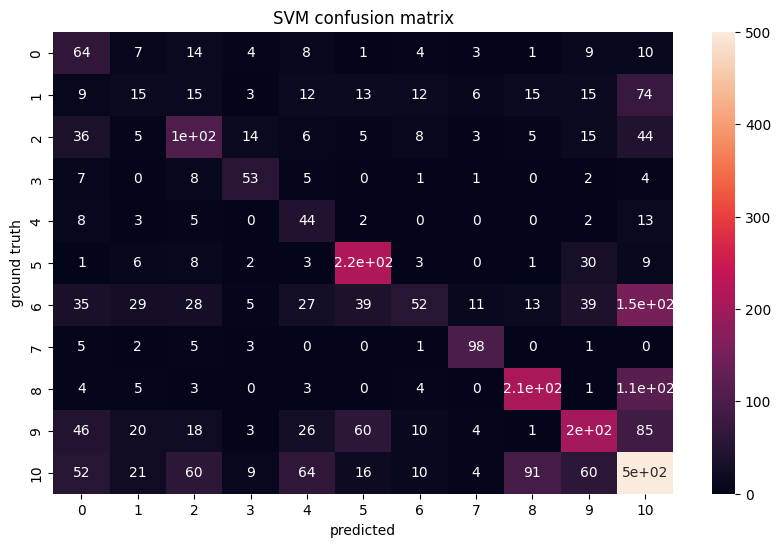

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, preds["svm"]["label"]), annot=True)
plt.xlabel("predicted")
plt.ylabel("ground truth")
plt.title("SVM confusion matrix")

Text(0.5, 1.0, 'KNN confusion matrix')

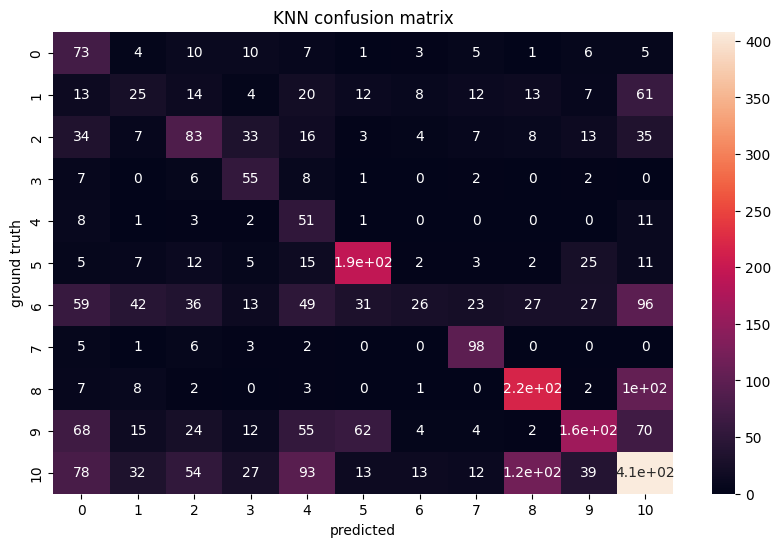

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, preds["knn"]["label"]), annot=True)
plt.xlabel("predicted")
plt.ylabel("ground truth")
plt.title("KNN confusion matrix")

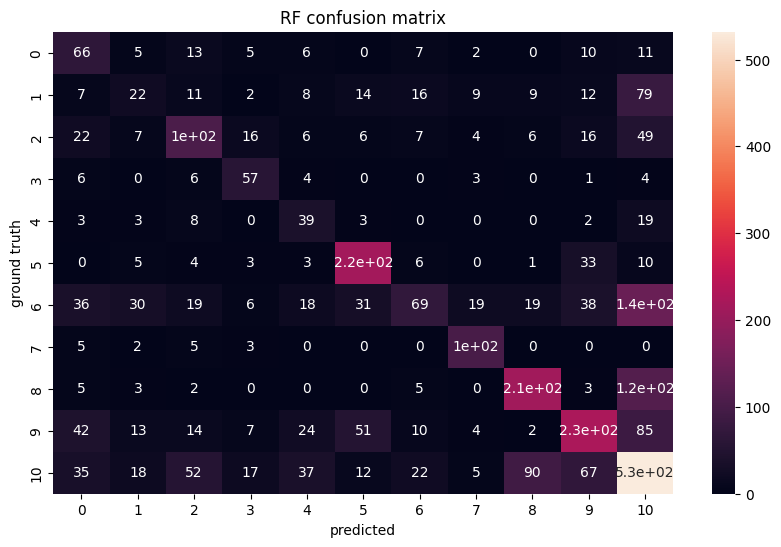

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, preds["rf"]["label"]), annot=True)
plt.xlabel("predicted")
plt.ylabel("ground truth")
plt.title("RF confusion matrix");

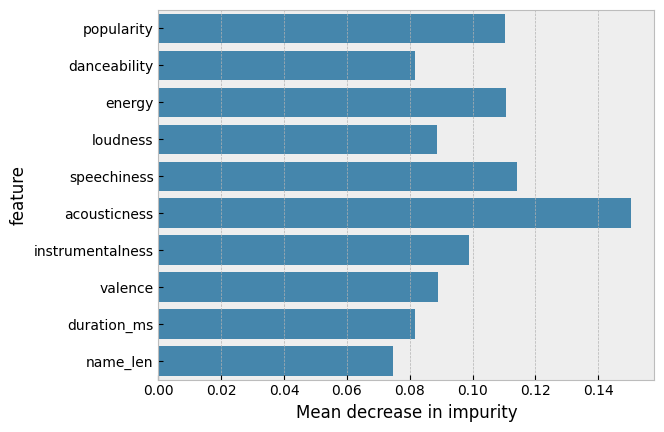

In [ ]:
# feature importances based on RandomForest
with plt.style.context("bmh"):
    sns.barplot(
        y=x_train.columns.to_list(),
        x=models["rf"].estimator.feature_importances_,
        orient="y"
    )
    plt.yticks(
        np.arange(x_train.shape[1]), x_train.columns.to_list()
    )
    plt.ylabel("feature")
    plt.xlabel("Mean decrease in impurity");